**Author :** Rutendo F. Sigauke

**Input  :** 

1. Further filtered significant pairs

2. Overlap files between bidirectionals and GTEx SNPs

3. Gene file from GTEx ('${tissue}$_egenes.txt.gz')

**Output :**

1. Gene and bidirectional pairs that overlap GTEx eQTLs 
    
        - sig_pairs_path_DT_filt_gtex_all_INTER.txt.gz
        
2. GTEx pairs that have overlaps with bidirection -- gene pairs

        - overlap_bed_DT_genename_bidirs_new_INTER.txt.gz

2. Figures (overlap with validated pairs)

# Introduction

Here, GTEx eQTLs are overlapped with gene and bidirectiona pairs. 

    1. SNPs are overlapped with **INTERGENIC** bidirectional transcripts

(with `bedtools intersect`)

    2. For those variants that overlap bidirectionals, the linked genes have to match
    
(Filtering and merging done in `R`)

    3. The fraction overlaps are compared to eQTLs that overlap intergenic bidirectionals

# Load libraries

In [1]:
library(ggplot2) ##plotting package
library(cowplot) ##plots + arrange plots etc
library(data.table) ## load files into R faster

# Functions

## Filter significant pairs

In [2]:
removing_DoPAD_bidirs <- function(pairs, dist_DoPAD=15000, abs_pcc=0.6, number_observed=10) {
    #' Remove pairs where the bidirectionals transcript is Downstream of Polyadenylation Site (DoPAD)
    #1. Subset by distance from TES
    pairs_dopad <- subset(pairs, 
                          abs(distance_tes) < dist_DoPAD & 
                          abs(pcc) > abs_pcc)
    
    #2. Label bidirectionals that fall closer to the TES than to the TSS
    pairs_dopad$filter <- ifelse(abs(pairs_dopad$distance_tss) < abs(pairs_dopad$distance_tes),
                                        FALSE, TRUE)
    
    pairs_dopad_removing <- pairs_dopad[pairs_dopad$filter=='TRUE',]

    #This removes any pairs with bidirectionals in DoPAD as opposed to only removing the pair
    pairs_keeping <- pairs[!pairs$transcript_2 %in% pairs_dopad_removing$transcript_2,]
    
    pairs_keeping_nObs <- subset(pairs_keeping, nObs > number_observed)
    return(pairs_keeping_nObs)
}

## Shuffle significant pairs

In [3]:
shuffle_genes <- function(pairs_DT, seed=1235){
    ##shuffle genes within a chromosome pairs
    
    set.seed(seed)
    pairs_DT_shuffled_genes <- pairs_DT
    
    #Reorder the gene ids in the input pairs
    pairs_DT_shuffled_genes$transcript_1 <- sample(pairs_DT$transcript_1, 
                                                     nrow(pairs_DT)) 
    return(pairs_DT_shuffled_genes)
   
}

## Get GTEx and dbNascent pair overlaps

In [4]:
gtex_dbnascent_pairs <- function(gtex_snp_bidir_overlap, gene_bidir_pairs){
    
    total_uniq_pairs_nascent <- nrow(unique(gene_bidir_pairs[,c('transcript_1','transcript_2')]))
    
    # 1. Merge gtex SNPs overlapping bidirectionals
    #with gene and bidirectional pairs by bidir_id.
    #N.B. Merge was done with bedtools intersect over SNP regions and bidirs
    merged_gtex_bidir_gene_pairs <- merge(gtex_snp_bidir_overlap,
                                          gene_bidir_pairs,
                                          by.x='bidir_id',
                                          by.y='transcript_2',
                                          all = TRUE, 
                                          allow.cartesian=TRUE)
    
    # 2. Overlaps will have complete cases
    merged_gtex_bidir_gene_pairs_complete <- merged_gtex_bidir_gene_pairs[complete.cases(merged_gtex_bidir_gene_pairs),]

    # 3. Get GTEx SNPs that overlap AND the are paired with the same gene
    merged_gtex_bidir_gene_pairs_match_genes <- unique(merged_gtex_bidir_gene_pairs_complete[gene_name==gene_id.y])
    
    # 4. Add bidirection-gene id
    merged_gtex_bidir_gene_pairs_match_genes$pair_id <- paste0(merged_gtex_bidir_gene_pairs_match_genes$transcript_1,
                                                               '~',
                                                               merged_gtex_bidir_gene_pairs_match_genes$bidir_id)
    
    # 5. Print summary statistics
    print("-----------------------------------------")
    print("-----------------------------------------")
    print(paste0("N GTEx SNPs                = ", length(unique(merged_gtex_bidir_gene_pairs_match_genes$gtex_snp_id))))
    print(paste0("N Bidirectionals           = ", length(unique(merged_gtex_bidir_gene_pairs_match_genes$bidir_id))))
    print(paste0("N Genes                    = ", length(unique(merged_gtex_bidir_gene_pairs_match_genes$gene_name))))
   
    print("-----------------------------------------")
    print(paste0("N Bidirectional~Gene Pairs = ", length(unique(merged_gtex_bidir_gene_pairs_match_genes$pair_id))))
   
    per_dbnascent <-signif((length(unique(merged_gtex_bidir_gene_pairs_match_genes$pair_id))/total_uniq_pairs_nascent)*100, 4)
    print(paste0("% Bidirectional~Gene Pairs = ", per_dbnascent, "%"))
    
    print("-----------------------------------------")
    n_gtex <- nrow(unique(gtex_snp_bidir_overlap[,c('gtex_snp_id','gene_name')]))
    
    print(paste0("N GTEx Pairs               = ", nrow(unique(merged_gtex_bidir_gene_pairs_match_genes[,c('gtex_snp_id','gene_name')]))))
    per_gtex <- signif((nrow(unique(merged_gtex_bidir_gene_pairs_match_genes[,c('gtex_snp_id','gene_name')]))/n_gtex)*100, 4)
    print(paste0("% GTEx Pairs               = ", per_gtex, "%"))
    print("-----------------------------------------")
    print("-----------------------------------------")
    return(merged_gtex_bidir_gene_pairs_match_genes)
}

# Pairs

## Significant pairs

In [5]:
sig_pairs_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/correlations/inter/significant'

##get paths for the counts tables
sig_pairs_path_files <- list.files(path=sig_pairs_path, 
                              pattern="*gz", 
                                   full.names=TRUE)

##load correlations
sig_pairs_path_DT_list <- lapply(sig_pairs_path_files, 
                                   data.table::fread) 


In [6]:
##combine to one data.table
sig_pairs_path_DT <- do.call(rbind, sig_pairs_path_DT_list)
print(paste0("Number of pairs = ",nrow(sig_pairs_path_DT)))

[1] "Number of pairs = 3663224"


In [7]:
sig_pairs_path_DT_filt <- removing_DoPAD_bidirs(sig_pairs_path_DT)
print(paste0("Number of pairs after filtering = ",nrow(sig_pairs_path_DT_filt)))

[1] "Number of pairs after filtering = 1440890"


In [8]:
sig_gene_bidir_pairs <- sig_pairs_path_DT_filt[,c('transcript_1',
                                                   'transcript_2')]
sig_gene_bidir_pairs$gene_id <- as.character(lapply(strsplit(sig_gene_bidir_pairs$transcript_1, ':'),
                                                      `[`, 1))
head(sig_gene_bidir_pairs, 3)

transcript_1,transcript_2,gene_id
<chr>,<chr>,<chr>
A3GALT2:NM_001080438.1,chr1:33036652-33037238,A3GALT2
A3GALT2:NM_001080438.1,chr1:33224694-33224966,A3GALT2
A3GALT2:NM_001080438.1,chr1:33242850-33243170,A3GALT2


## Significant pairs: Shuffled bidirectionals and genes

In [9]:
#1. Shuffle the pairs
sig_pairs_path_DT_shuffle_list <- lapply(sig_pairs_path_DT_list, shuffle_genes)
sig_pairs_path_DT_shuffle <- do.call(rbind, sig_pairs_path_DT_shuffle_list)
print(paste0("Number of shuffled pairs = ", nrow(sig_pairs_path_DT_shuffle)))

[1] "Number of shuffled pairs = 3663224"


In [10]:
##filter the shuffled pairs
sig_pairs_path_DT_shuffle_filtered <- removing_DoPAD_bidirs(sig_pairs_path_DT_shuffle)
print(paste0("Number of shuffled pairs after filtering = ", nrow(sig_pairs_path_DT_shuffle_filtered)))

[1] "Number of shuffled pairs after filtering = 1440890"


In [11]:
#get gene and bidirectional transcripts
sig_gene_bidir_pairs_shuffled <- sig_pairs_path_DT_shuffle_filtered[,c('transcript_1',
                                                   'transcript_2')]
sig_gene_bidir_pairs_shuffled$gene_id <- as.character(lapply(strsplit(sig_gene_bidir_pairs_shuffled$transcript_1, ':'),
                                                      `[`, 1))
head(sig_gene_bidir_pairs_shuffled, 3)

transcript_1,transcript_2,gene_id
<chr>,<chr>,<chr>
CDC73:NM_024529.5,chr1:33036652-33037238,CDC73
NBPF14:NM_015383.2,chr1:33224694-33224966,NBPF14
ACTG1P20:NR_033926.1,chr1:33242850-33243170,ACTG1P20


# GTEx  and bidirectional intersect

`30_GTEx_pairs_overlap_inter_bidirectionals.sbatch`



```sh

#!/bin/bash

#SBATCH --job-name=gtex_nascent_overlaps
#SBATCH --output=/scratch/Users/rusi2317/e_and_o/%x_%j.out
#SBATCH --error=/scratch/Users/rusi2317/e_and_o/%x_%j.err
#SBATCH --time=02:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem=100MB
#SBATCH --partition short
#SBATCH --mail-type=FAIL
#SBATCH --mail-user=rutendo.sigauke@cuanschutz.edu

module purge
module load bedtools/2.28.0

###########################
##initialize files       ## 
###########################
wd=/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38
gtex=${wd}/enhancers/GTEx_Analysis_v8_eQTL
bidirs=${wd}/processed_data/counts/normalized/genes_inter_bidir_filtered.tsv.gz
outdir=${wd}/processed_data/gtex_inter_bidir_intersect

mkdir -p ${outdir}

home=/Users/rusi2317/projects/meta_analysis_qc/hg38
gtex_home=${home}/enhancers/GTEx_Analysis_v8_eQTL

###########################
##Get overlaps ############
###########################
#0: create a bed file for intergenic bidirectionals
zcat ${bidirs} | grep -v 'start' | cut -f 1-6 | grep -v '_' | sort -k 1,1 -k2,2n > ${outdir}/intergenic_bidirs_counted.bed

#1: get significant pairs from home directory

rsync -Pravz \
    ${gtex_home}/*signif_variant_gene_pairs.txt.gz \
    ${gtex}

#2: unzip signif_variants files from GTEx
#tissue=Whole_Blood

for tissue in `ls ${gtex} | grep 'signif_variant_gene_pairs' | tr '.' '\t' | cut -f 1 `; do

    sigvar=${gtex}/${tissue}.v8.signif_variant_gene_pairs.txt.gz

    #3: get variant and gene ids
    zcat ${sigvar} | grep -v 'gene_id' | cut -f 1,2 | tr '_' '\t' | awk -F'\t' '{print $1,$2-1,$2,$3,$4,$5,$6}' OFS='\t' > ${outdir}/${tissue}_egene_variant.bed

    #4 Overlap gtex variants with bidirectionals
    bedtools intersect -a ${outdir}/${tissue}_egene_variant.bed -b ${outdir}/intergenic_bidirs_counted.bed -wa -wb | uniq > ${outdir}/${tissue}_gtex_inter_bidir_intersect.bed

    #7: delete intermediate files
    rm ${outdir}/${tissue}_egene_variant.bed

done

echo "DONE!"

```

## GTEx overlapping intergenic bidirectional transcripts

In [12]:
gtex_overlap_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gtex_inter_bidir_intersect'

##get paths
gtex_overlap_files <- list.files(path=gtex_overlap_path, 
                              pattern="*_intersect.bed", 
                                   full.names=TRUE)

##load overlaps
gtex_overlap_bed_DT_list <- lapply(gtex_overlap_files, 
                                   data.table::fread) 

In [13]:
##add tissue ids
gtex_overlap_file_names <- basename(gtex_overlap_files)
 
gtex_tissue_names <- gsub("_", " ", as.character(lapply(strsplit(gtex_overlap_file_names, '_gtex'), `[`, 1)))
print("---GTEx Tissues---")
gtex_tissue_names
print("------------------")

#Name each of the lists. by tissue id
#names(gtex_overlap_bed_DT_list) <- gtex_tissue_names

[1] "---GTEx Tissues---"


[1] "Adipose Subcutaneous"                 
 [2] "Adipose Visceral Omentum"             
 [3] "Adrenal Gland"                        
 [4] "Artery Aorta"                         
 [5] "Artery Coronary"                      
 [6] "Artery Tibial"                        
 [7] "Brain Amygdala"                       
 [8] "Brain Anterior cingulate cortex BA24" 
 [9] "Brain Caudate basal ganglia"          
[10] "Brain Cerebellar Hemisphere"          
[11] "Brain Cerebellum"                     
[12] "Brain Cortex"                         
[13] "Brain Frontal Cortex BA9"             
[14] "Brain Hippocampus"                    
[15] "Brain Hypothalamus"                   
[16] "Brain Nucleus accumbens basal ganglia"
[17] "Brain Putamen basal ganglia"          
[18] "Brain Spinal cord cervical c-1"       
[19] "Brain Substantia nigra"               
[20] "Breast Mammary Tissue"                
[21] "Cells Cultured fibroblasts"           
[22] "Cells EBV-transformed lymphocytes"    
[23] "Colon Sigmoid"                        
[24] "Colon Transverse"                     
[25] "Esophagus Gastroesophageal Junction"  
[26] "Esophagus Mucosa"                     
[27] "Esophagus Muscularis"                 
[28] "Heart Atrial Appendage"               
[29] "Heart Left Ventricle"                 
[30] "Kidney Cortex"                        
[31] "Liver"                                
[32] "Lung"                                 
[33] "Minor Salivary Gland"                 
[34] "Muscle Skeletal"                      
[35] "Nerve Tibial"                         
[36] "Ovary"                                
[37] "Pancreas"                             
[38] "Pituitary"                            
[39] "Prostate"                             
[40] "Skin Not Sun Exposed Suprapubic"      
[41] "Skin Sun Exposed Lower leg"           
[42] "Small Intestine Terminal Ileum"       
[43] "Spleen"                               
[44] "Stomach"                              
[45] "Testis"                               
[46] "Thyroid"                              
[47] "Uterus"                               
[48] "Vagina"                               
[49] "Whole Blood"

[1] "------------------"


In [14]:
#add a column with the tissue label from GTEx
for (i in 1:length(gtex_overlap_bed_DT_list)){
    
    gtex_overlap_bed_DT_list[[i]]$gtex_tissue <- gtex_tissue_names[i]

}

In [15]:
##Combine all the tables
overlap_bed_DT <- unique(do.call(rbind, gtex_overlap_bed_DT_list))
head(overlap_bed_DT, 3)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,gtex_tissue
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>
chr1,666027,666028,G,A,b38,ENSG00000227232.5,chr1,665707,666413,chr1:665707-666413,2,.,Adipose Subcutaneous
chr1,502652,502653,G,T,b38,ENSG00000269981.1,chr1,502565,502741,chr1:502565-502741,5,.,Adipose Subcutaneous
chr1,502652,502653,G,T,b38,ENSG00000279457.4,chr1,502565,502741,chr1:502565-502741,5,.,Adipose Subcutaneous


In [16]:
##Relabel the columns (A)
colnames(overlap_bed_DT) <- c('chr_variant','start_variant','end_variant',
                             'ref_variant','alt_variant','ref', 'gene_id',
                             'chr_bidir','start_bidir','end_bidir','bidir_id',
                              'bidir_score','bidir_strand','gtex_tissue')

#Add a new column with a bidirectional ID
overlap_bed_DT[,("gtex_snp_id"):=paste0(chr_variant,':',
                                     start_variant,'-',
                                     end_variant)]

print(paste0("GTEx pairs with variant overlapping bidirectionas = ", nrow(overlap_bed_DT)))
head(overlap_bed_DT, 3)

[1] "GTEx pairs with variant overlapping bidirectionas = 5027571"


chr_variant,start_variant,end_variant,ref_variant,alt_variant,ref,gene_id,chr_bidir,start_bidir,end_bidir,bidir_id,bidir_score,bidir_strand,gtex_tissue,gtex_snp_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>
chr1,666027,666028,G,A,b38,ENSG00000227232.5,chr1,665707,666413,chr1:665707-666413,2,.,Adipose Subcutaneous,chr1:666027-666028
chr1,502652,502653,G,T,b38,ENSG00000269981.1,chr1,502565,502741,chr1:502565-502741,5,.,Adipose Subcutaneous,chr1:502652-502653
chr1,502652,502653,G,T,b38,ENSG00000279457.4,chr1,502565,502741,chr1:502565-502741,5,.,Adipose Subcutaneous,chr1:502652-502653


In [17]:
print(paste0("UNIQUE GTEx variant overlapping bidirectionas = ", 
             length(unique(overlap_bed_DT$gtex_snp_id))))

print(paste0("UNIQUE GTEx pairs with variant overlapping bidirectionas = ", 
             nrow(unique(overlap_bed_DT[,c('gtex_snp_id','gene_id')]))))

[1] "UNIQUE GTEx variant overlapping bidirectionas = 296344"
[1] "UNIQUE GTEx pairs with variant overlapping bidirectionas = 959511"


## Get Ensembl gene IDs to match gene names

### eGene and ids



In [18]:
#path to GTEx 
egene_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL'

#load egenes files
egene_files <- list.files(path=egene_path, 
                              pattern="*.egenes.txt.gz", 
                                   full.names=TRUE)
#store files in lists
egene_files_DT_list <- lapply(egene_files, 
                           data.table::fread)

#combine all egenes files
egene_files_DT <- do.call(rbind, egene_files_DT_list)

#get unique gene names and gene ids
egene_files_DT_uniq <- unique(egene_files_DT[,c('gene_id','gene_name')])
print(paste("GTEx Genes = ", nrow(egene_files_DT_uniq)))
head(egene_files_DT_uniq, 2)

[1] "GTEx Genes =  39832"


gene_id,gene_name
<chr>,<chr>
ENSG00000227232.5,WASH7P
ENSG00000268903.1,RP11-34P13.15


### Get matching genes for variant-bidirectional overlaps

Merge to get gene_names from GTEx

In [19]:
overlap_bed_DT_genename <- merge(overlap_bed_DT, 
                                 egene_files_DT_uniq,
                                 by='gene_id')

dim(overlap_bed_DT_genename)
head(overlap_bed_DT_genename, 2)

[1] 5027571      16

gene_id,chr_variant,start_variant,end_variant,ref_variant,alt_variant,ref,chr_bidir,start_bidir,end_bidir,bidir_id,bidir_score,bidir_strand,gtex_tissue,gtex_snp_id,gene_name
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
ENSG00000000003.14,chrX,100548180,100548181,A,G,b38,chrX,100548120,100548420,chrX:100548120-100548420,1,.,Adipose Subcutaneous,chrX:100548180-100548181,TSPAN6
ENSG00000000003.14,chrX,100609852,100609853,A,T,b38,chrX,100609211,100609953,chrX:100609211-100609953,2,.,Adipose Subcutaneous,chrX:100609852-100609853,TSPAN6


# Checking dbNascent pairs vs. shuffled

## True pairs

In [20]:
bidir_pairs_overlap_gtex <- gtex_dbnascent_pairs(gtex_snp_bidir_overlap=overlap_bed_DT_genename, 
                                                 gene_bidir_pairs=sig_gene_bidir_pairs) 
                                        

[1] "-----------------------------------------"
[1] "-----------------------------------------"
[1] "N GTEx SNPs                = 85527"
[1] "N Bidirectionals           = 43553"
[1] "N Genes                    = 14269"
[1] "-----------------------------------------"
[1] "N Bidirectional~Gene Pairs = 81046"
[1] "% Bidirectional~Gene Pairs = 7.407%"
[1] "-----------------------------------------"
[1] "N GTEx Pairs               = 146550"
[1] "% GTEx Pairs               = 15.28%"
[1] "-----------------------------------------"
[1] "-----------------------------------------"


## Shuffled pairs

In [21]:
bidir_pairs_overlap_gtex_shuffled <- gtex_dbnascent_pairs(gtex_snp_bidir_overlap=overlap_bed_DT_genename, 
                                                 gene_bidir_pairs=sig_gene_bidir_pairs_shuffled) 


[1] "-----------------------------------------"
[1] "-----------------------------------------"
[1] "N GTEx SNPs                = 5679"
[1] "N Bidirectionals           = 3047"
[1] "N Genes                    = 2494"
[1] "-----------------------------------------"
[1] "N Bidirectional~Gene Pairs = 3853"
[1] "% Bidirectional~Gene Pairs = 0.2716%"
[1] "-----------------------------------------"
[1] "N GTEx Pairs               = 6911"
[1] "% GTEx Pairs               = 0.7205%"
[1] "-----------------------------------------"
[1] "-----------------------------------------"


# Plots for pairs

## Distance distributions

In [22]:
sig_pairs_path_DT_filt$pair_id <- paste0(sig_pairs_path_DT_filt$transcript_1,
                                         '~',
                                        sig_pairs_path_DT_filt$transcript_2)
head(sig_pairs_path_DT_filt)

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847,A3GALT2:NM_001080438.1~chr1:33036652-33037238
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207,A3GALT2:NM_001080438.1~chr1:33224694-33224966
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,1.706406e-04,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910,A3GALT2:NM_001080438.1~chr1:33242850-33243170
chr1,93992833,94121148,ABCA4:NM_000350.3,.,-,chr1,93910534,93911046,chr1:93910534-93911046,⋯,5.905776e-13,6.731068e-11,86,8.504139,210358,82043,downstream,blood,38.738739,ABCA4:NM_000350.3~chr1:93910534-93911046
chr1,93992833,94121148,ABCA4:NM_000350.3,.,-,chr1,93931066,93931248,chr1:93931066-93931248,⋯,5.196389e-06,1.088703e-04,35,5.429220,189991,61676,downstream,blood,15.765766,ABCA4:NM_000350.3~chr1:93931066-93931248
chr1,93992833,94121148,ABCA4:NM_000350.3,.,-,chr1,93946840,93947120,chr1:93946840-93947120,⋯,2.185860e-07,6.991417e-06,38,6.376853,174168,45853,downstream,blood,17.117117,ABCA4:NM_000350.3~chr1:93946840-93947120


In [23]:
sig_pairs_path_DT_filt$gtex <- ifelse(sig_pairs_path_DT_filt$pair_id %in% 
                                      bidir_pairs_overlap_gtex$pair_id,
                                     '1', '0')
head(sig_pairs_path_DT_filt)

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id,gtex
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847,A3GALT2:NM_001080438.1~chr1:33036652-33037238,0
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207,A3GALT2:NM_001080438.1~chr1:33224694-33224966,0
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33242850,33243170,chr1:33242850-33243170,⋯,2.060092e-03,22,4.606764,78088,63755,downstream,blood,9.909910,A3GALT2:NM_001080438.1~chr1:33242850-33243170,0
chr1,93992833,94121148,ABCA4:NM_000350.3,.,-,chr1,93910534,93911046,chr1:93910534-93911046,⋯,6.731068e-11,86,8.504139,210358,82043,downstream,blood,38.738739,ABCA4:NM_000350.3~chr1:93910534-93911046,0
chr1,93992833,94121148,ABCA4:NM_000350.3,.,-,chr1,93931066,93931248,chr1:93931066-93931248,⋯,1.088703e-04,35,5.429220,189991,61676,downstream,blood,15.765766,ABCA4:NM_000350.3~chr1:93931066-93931248,0
chr1,93992833,94121148,ABCA4:NM_000350.3,.,-,chr1,93946840,93947120,chr1:93946840-93947120,⋯,6.991417e-06,38,6.376853,174168,45853,downstream,blood,17.117117,ABCA4:NM_000350.3~chr1:93946840-93947120,0


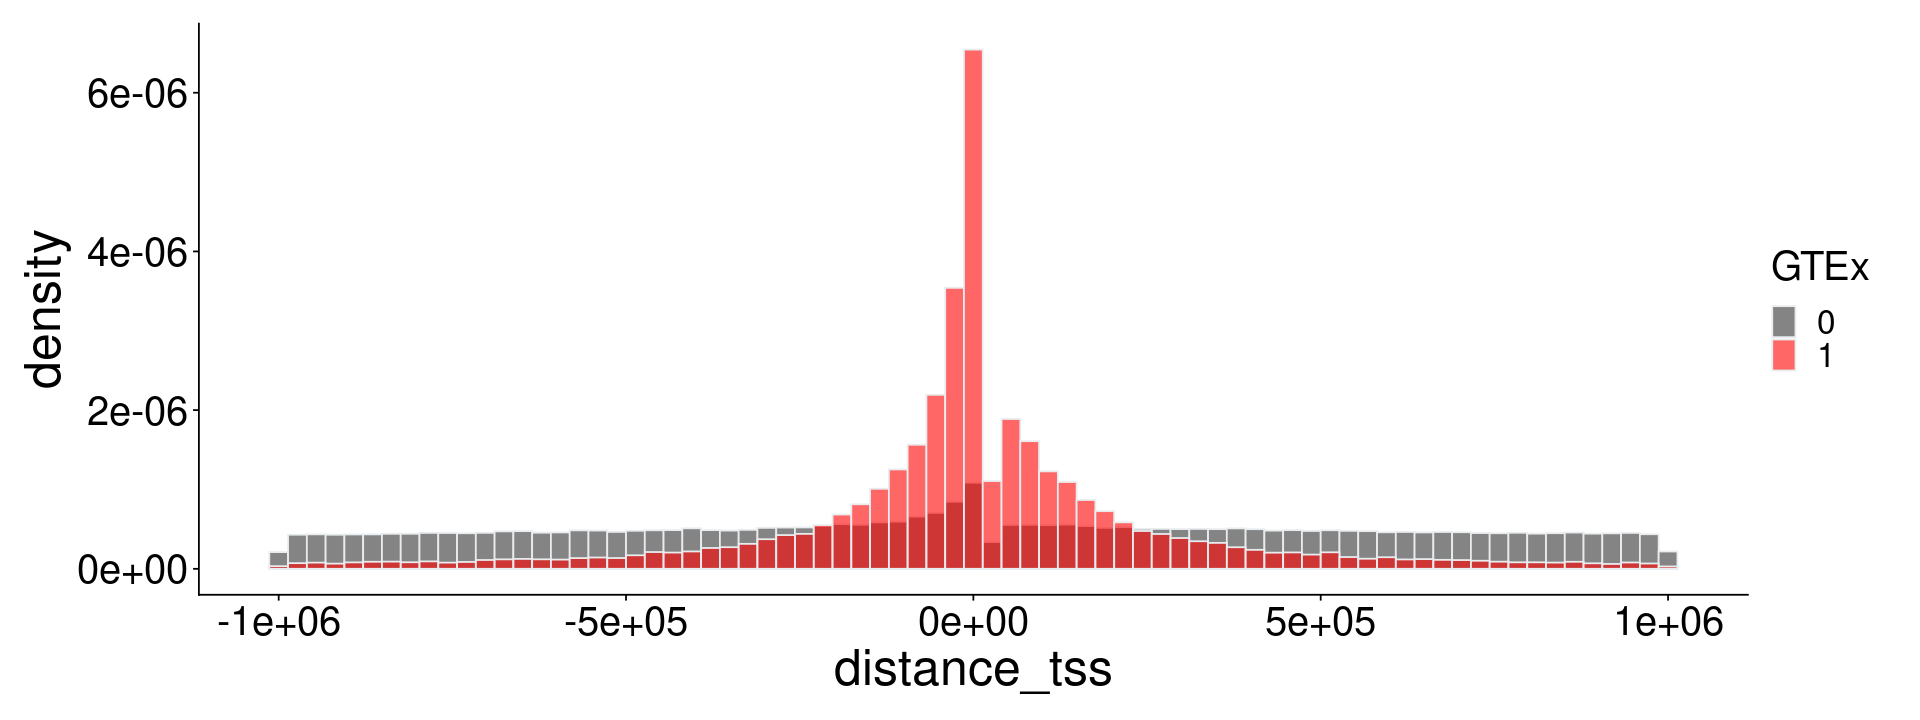

In [24]:
options(repr.plot.width=16, repr.plot.height=6)

ggplot(sig_pairs_path_DT_filt, aes(x=distance_tss, fill=gtex)) +
    geom_histogram(aes(y = ..density..), 
                   color="#e9ecef", 
                   alpha=0.6, 
                   position = 
                   'identity', 
                   bins = 75) +
    scale_fill_manual(values=c("gray20","red")) +
    theme_cowplot() +
    labs(fill="GTEx") +
theme(plot.title = element_text(hjust = 0.5, face = "plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24),
     legend.title = element_text(size = 24),
     legend.text = element_text(size = 20))+
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

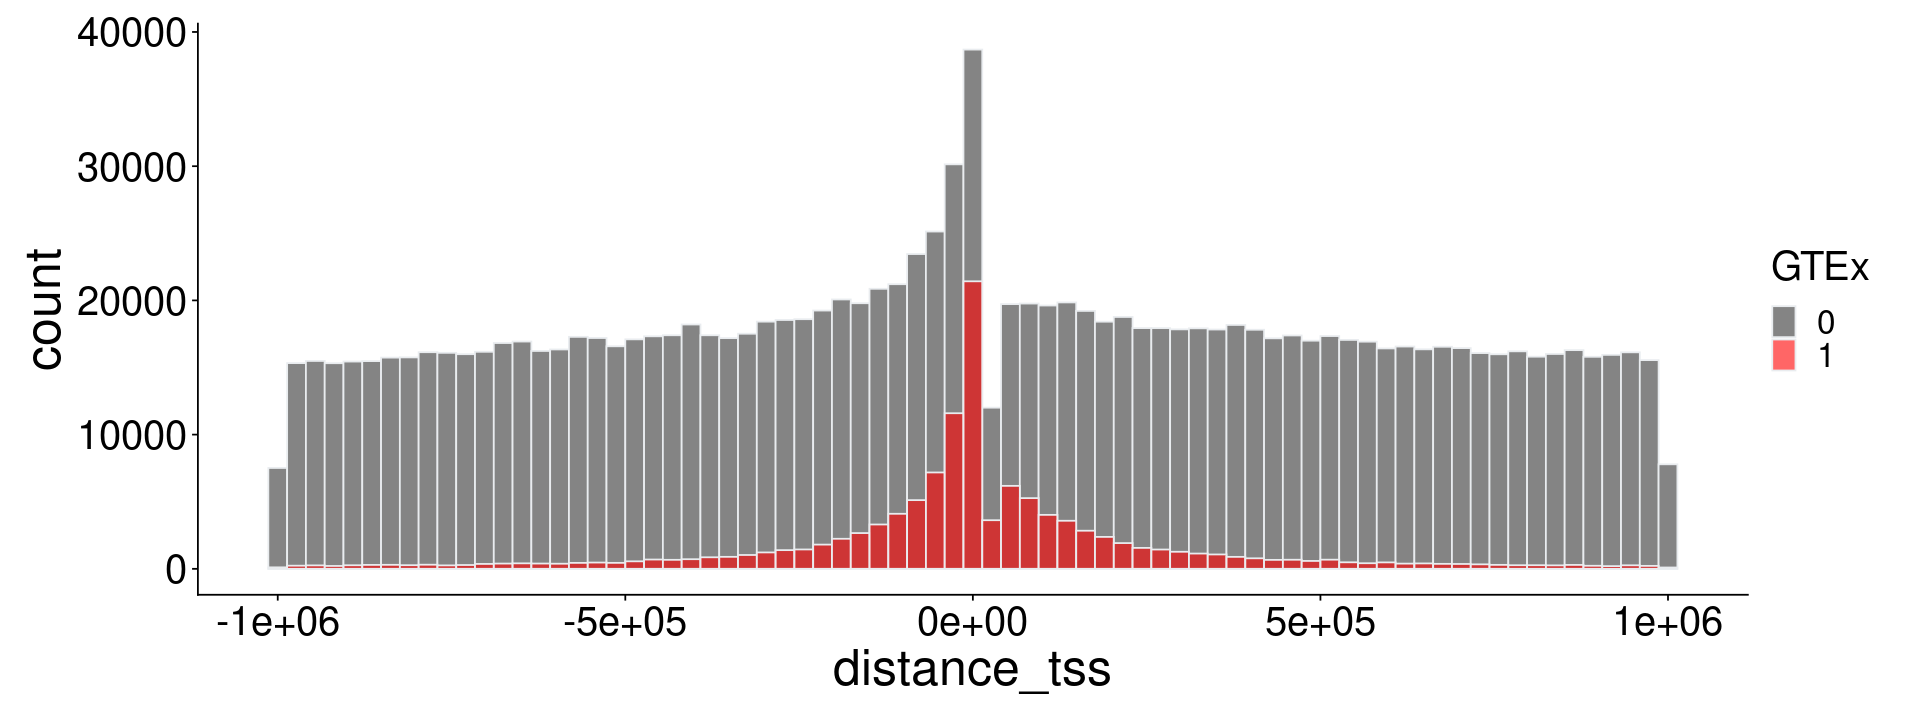

In [25]:
options(repr.plot.width=16, repr.plot.height=6)

ggplot(sig_pairs_path_DT_filt, aes(x=distance_tss, fill=gtex)) +
    geom_histogram( 
                   color="#e9ecef", 
                   alpha=0.6, 
                   position = 
                   'identity', 
                   bins = 75) +
    scale_fill_manual(values=c("gray20","red")) +
    theme_cowplot() +
    labs(fill="GTEx") +
theme(plot.title = element_text(hjust = 0.5, face = "plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24),
     legend.title = element_text(size = 24),
     legend.text = element_text(size = 20))+
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



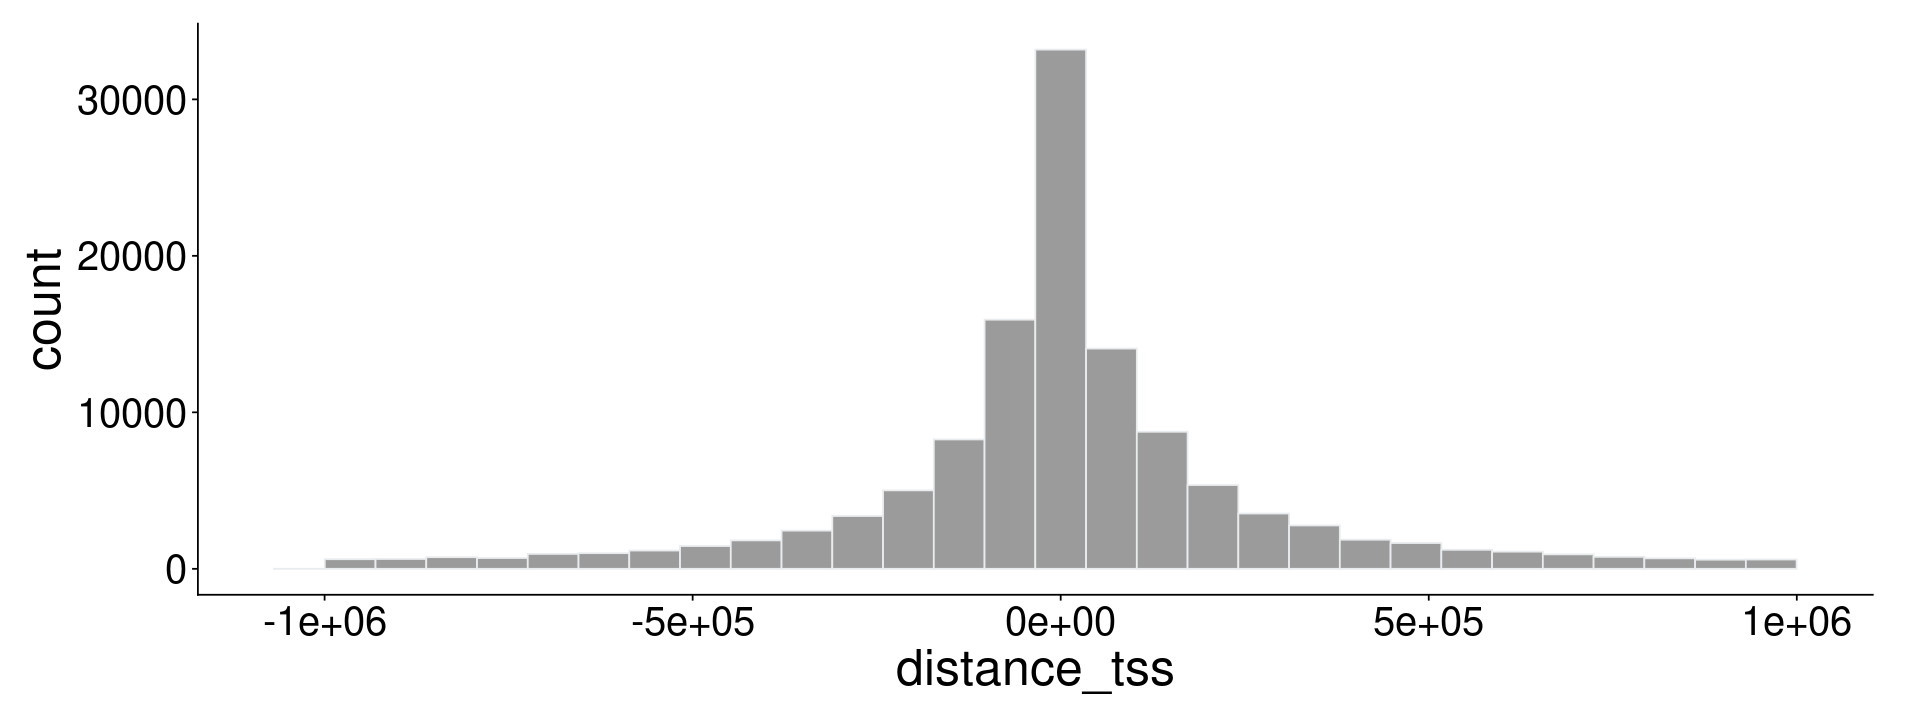

In [26]:
options(repr.plot.width=16, repr.plot.height=6)

ggplot(subset(sig_pairs_path_DT_filt, gtex=='1'), 
       aes(x=distance_tss)) +
    geom_histogram( color="#e9ecef", alpha=0.6, position = 'identity') +
    scale_fill_manual(values=c("#69b3a2", "#404080")) +
    theme_cowplot() +
    labs(fill="") +
theme(plot.title = element_text(hjust = 0.5, face = "plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24),
     legend.title = element_text(size = 24),
     legend.text = element_text(size = 20))+
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



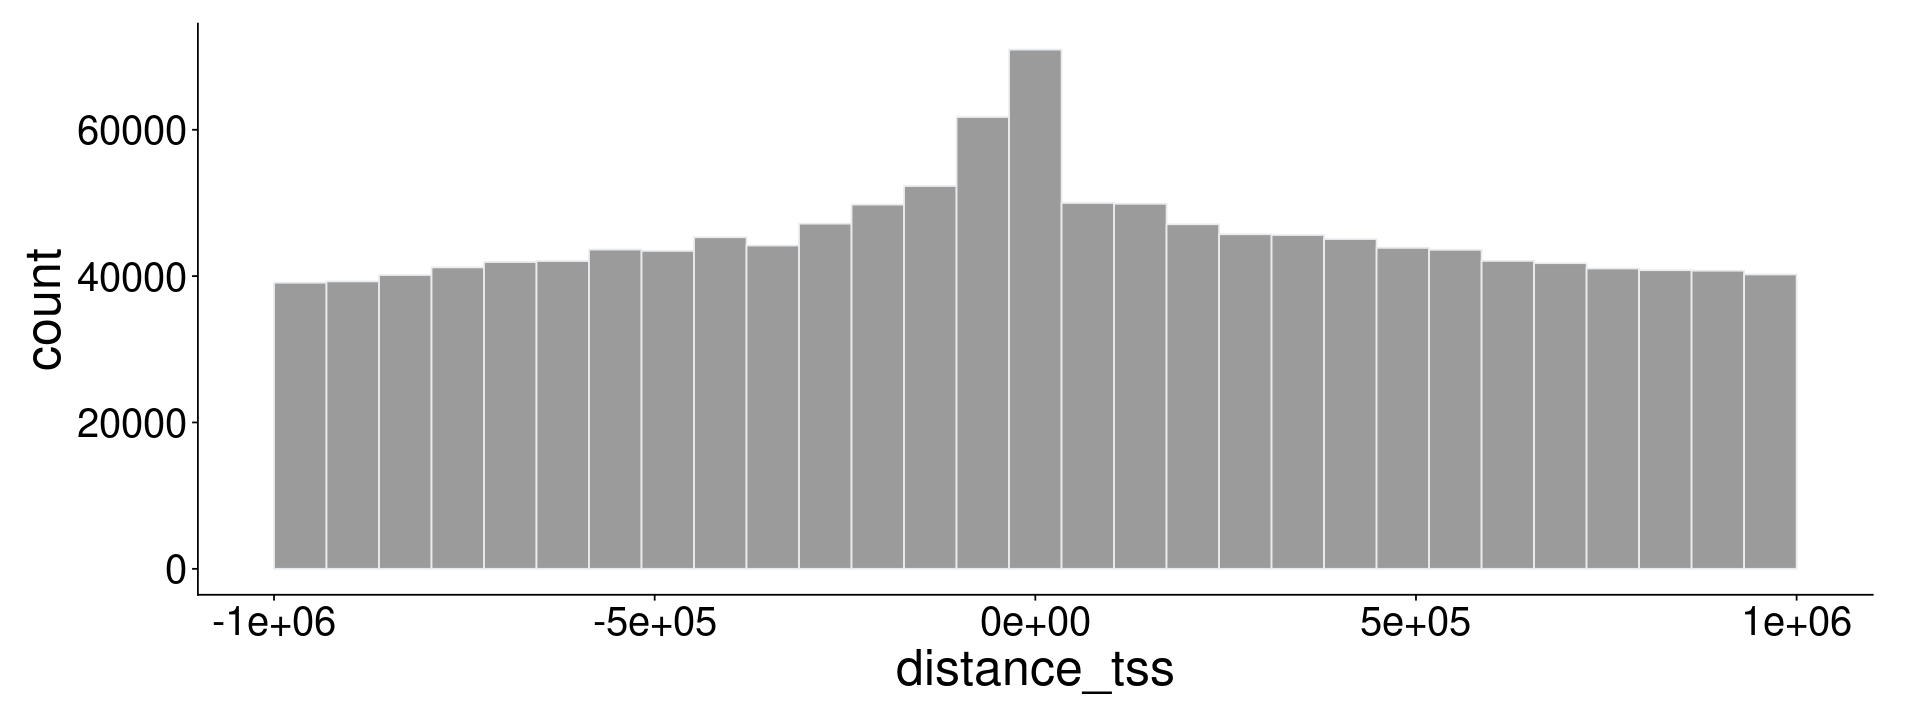

In [27]:
options(repr.plot.width=16, repr.plot.height=6)

ggplot(subset(sig_pairs_path_DT_filt, gtex=='0'), 
       aes(x=distance_tss)) +
    geom_histogram( color="#e9ecef", alpha=0.6, position = 'identity') +
    scale_fill_manual(values=c("#69b3a2", "#404080")) +
    theme_cowplot() +
    labs(fill="") +
theme(plot.title = element_text(hjust = 0.5, face = "plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24),
     legend.title = element_text(size = 24),
     legend.text = element_text(size = 20))+
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

## PCC and distance densities

In [28]:
head(subset(sig_pairs_path_DT_filt, gtex==1))

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id,gtex
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94310249,94311127,chr1:94310249-94311127,⋯,4.657652e-06,21,8.106376,-107700,-168035,upstream,blood,9.459459,ABCD3:NM_001122674.2~chr1:94310249-94311127,1
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94347033,94348559,chr1:94347033-94348559,⋯,3.478977e-06,22,8.085675,-70592,-130927,upstream,blood,9.909910,ABCD3:NM_001122674.2~chr1:94347033-94348559,1
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94382060,94382668,chr1:94382060-94382668,⋯,2.548884e-04,32,5.178511,-36024,-96359,upstream,blood,14.414414,ABCD3:NM_001122674.2~chr1:94382060-94382668,1
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94384921,94385259,chr1:94384921-94385259,⋯,1.933635e-07,78,6.659129,-33298,-93633,upstream,blood,35.135135,ABCD3:NM_001122674.2~chr1:94384921-94385259,1
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94566576,94567348,chr1:94566576-94567348,⋯,2.678685e-05,38,5.875028,148574,88239,downstream,blood,17.117117,ABCD3:NM_001122674.2~chr1:94566576-94567348,1
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94590531,94591849,chr1:94590531-94591849,⋯,1.310936e-03,34,4.445454,172802,112467,downstream,blood,15.315315,ABCD3:NM_001122674.2~chr1:94590531-94591849,1


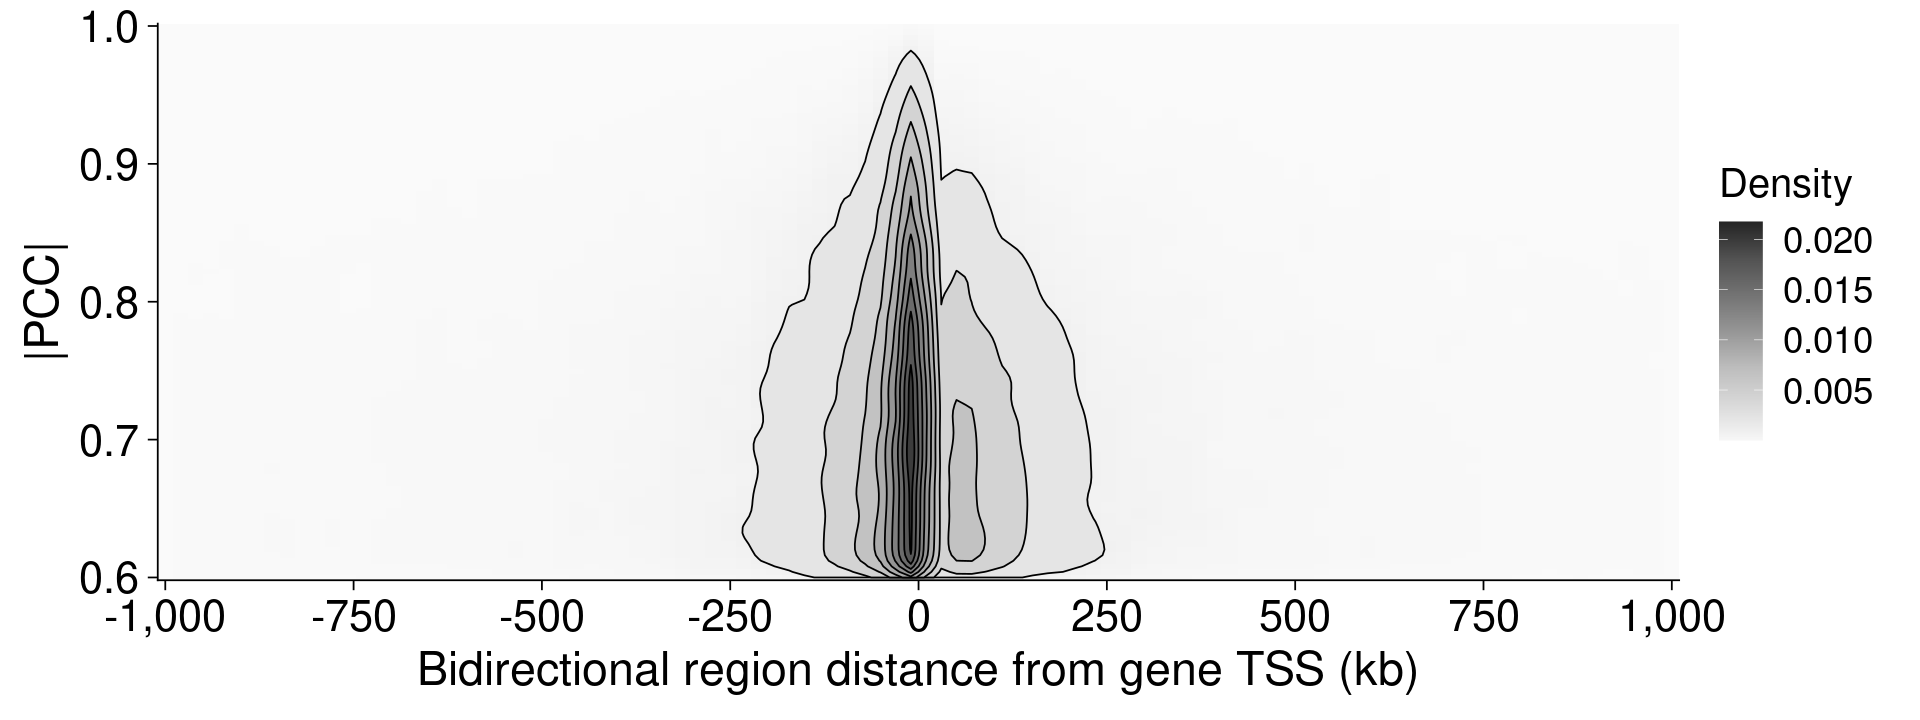

In [37]:
options(repr.plot.width=16, repr.plot.height=6)

dist_pcc_all_gtex <- ggplot(subset(sig_pairs_path_DT_filt, gtex=='1'), 
                              aes(x=distance_tss/1000, y=abs(pcc))) + 
stat_density_2d(geom = "raster", 
                aes(fill = ..density..),
                contour = F, alpha=0.5) +
stat_density_2d(geom = "polygon", contour = TRUE,
                  aes(fill = after_stat(level)), 
                colour = "black",
                  bins = 10) +
#ggtitle("Bidirectional and gene pairs overlapping GTEx") +
ylab("|PCC|")+
xlab('Bidirectional region distance from gene TSS (kb)') + 
theme_cowplot(24) +
scale_x_continuous(expand = c(0, 0),
                   breaks=seq(-1000,1000,250),
                  labels = scales::comma) +
scale_y_continuous(#limits=c(0.6, 1),
                    expand = c(0, 0)) +
scale_fill_distiller(palette= "Greys", direction=1, name="Density") +
theme(plot.title = element_text(hjust = 0.5, face = "plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 26),
      axis.text.y = element_text(size = 26),
     legend.title = element_text(size = 24),
     legend.text = element_text(size = 22))+
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

dist_pcc_all_gtex

In [38]:
ggsave(dist_pcc_all_gtex, width = 16, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/dist_pcc_all_gtex_greys.pdf',
      bg = "transparent")

ggsave(dist_pcc_all_gtex, width = 16, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/dist_pcc_all_gtex_greys.png',
      bg = "transparent")

In [31]:
sig_pairs_path_DT_filt_gtex_all <- sig_pairs_path_DT_filt[sig_pairs_path_DT_filt$pair_id %in% bidir_pairs_overlap_gtex$pair_id, ]
nrow(sig_pairs_path_DT_filt_gtex_all)
print(paste0("# Unique pairs in GTEx ", 
             length(unique(sig_pairs_path_DT_filt_gtex_all$pair_id))))
head(sig_pairs_path_DT_filt_gtex_all, 3)

[1] 121132

[1] "# Unique pairs in GTEx 81046"


transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id,gtex
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94310249,94311127,chr1:94310249-94311127,⋯,4.657652e-06,21,8.106376,-107700,-168035,upstream,blood,9.459459,ABCD3:NM_001122674.2~chr1:94310249-94311127,1
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94347033,94348559,chr1:94347033-94348559,⋯,3.478977e-06,22,8.085675,-70592,-130927,upstream,blood,9.909910,ABCD3:NM_001122674.2~chr1:94347033-94348559,1
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94382060,94382668,chr1:94382060-94382668,⋯,2.548884e-04,32,5.178511,-36024,-96359,upstream,blood,14.414414,ABCD3:NM_001122674.2~chr1:94382060-94382668,1


In [32]:
data.table::fwrite(sig_pairs_path_DT_filt_gtex_all,
                  "/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gtex_bidir_significant_pairs/sig_pairs_path_DT_filt_gtex_all_INTER.txt.gz",
                  sep='\t')

data.table::fwrite(bidir_pairs_overlap_gtex,
                  "/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gtex_bidir_significant_pairs/overlap_bed_DT_genename_bidirs_new_INTER.txt.gz",
                  sep='\t')

## Location of pairs on chromosomes

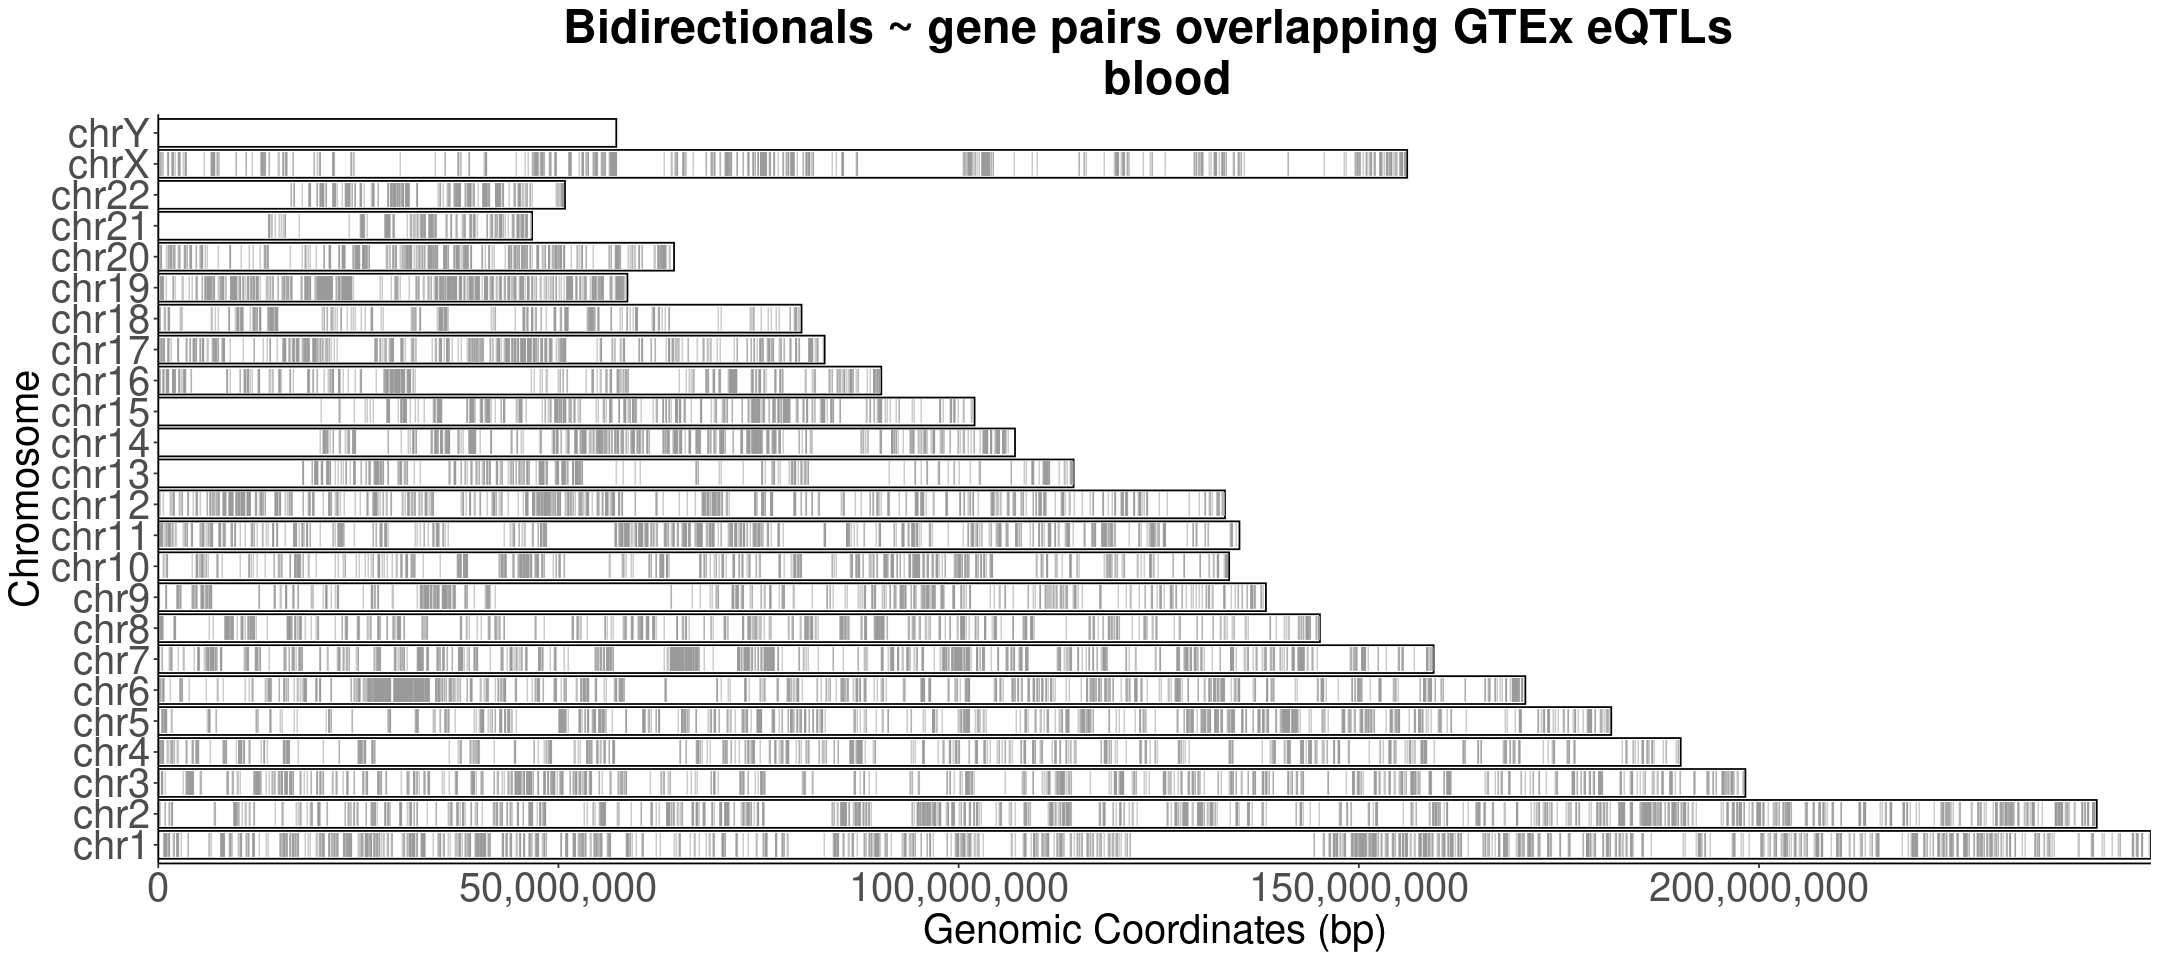

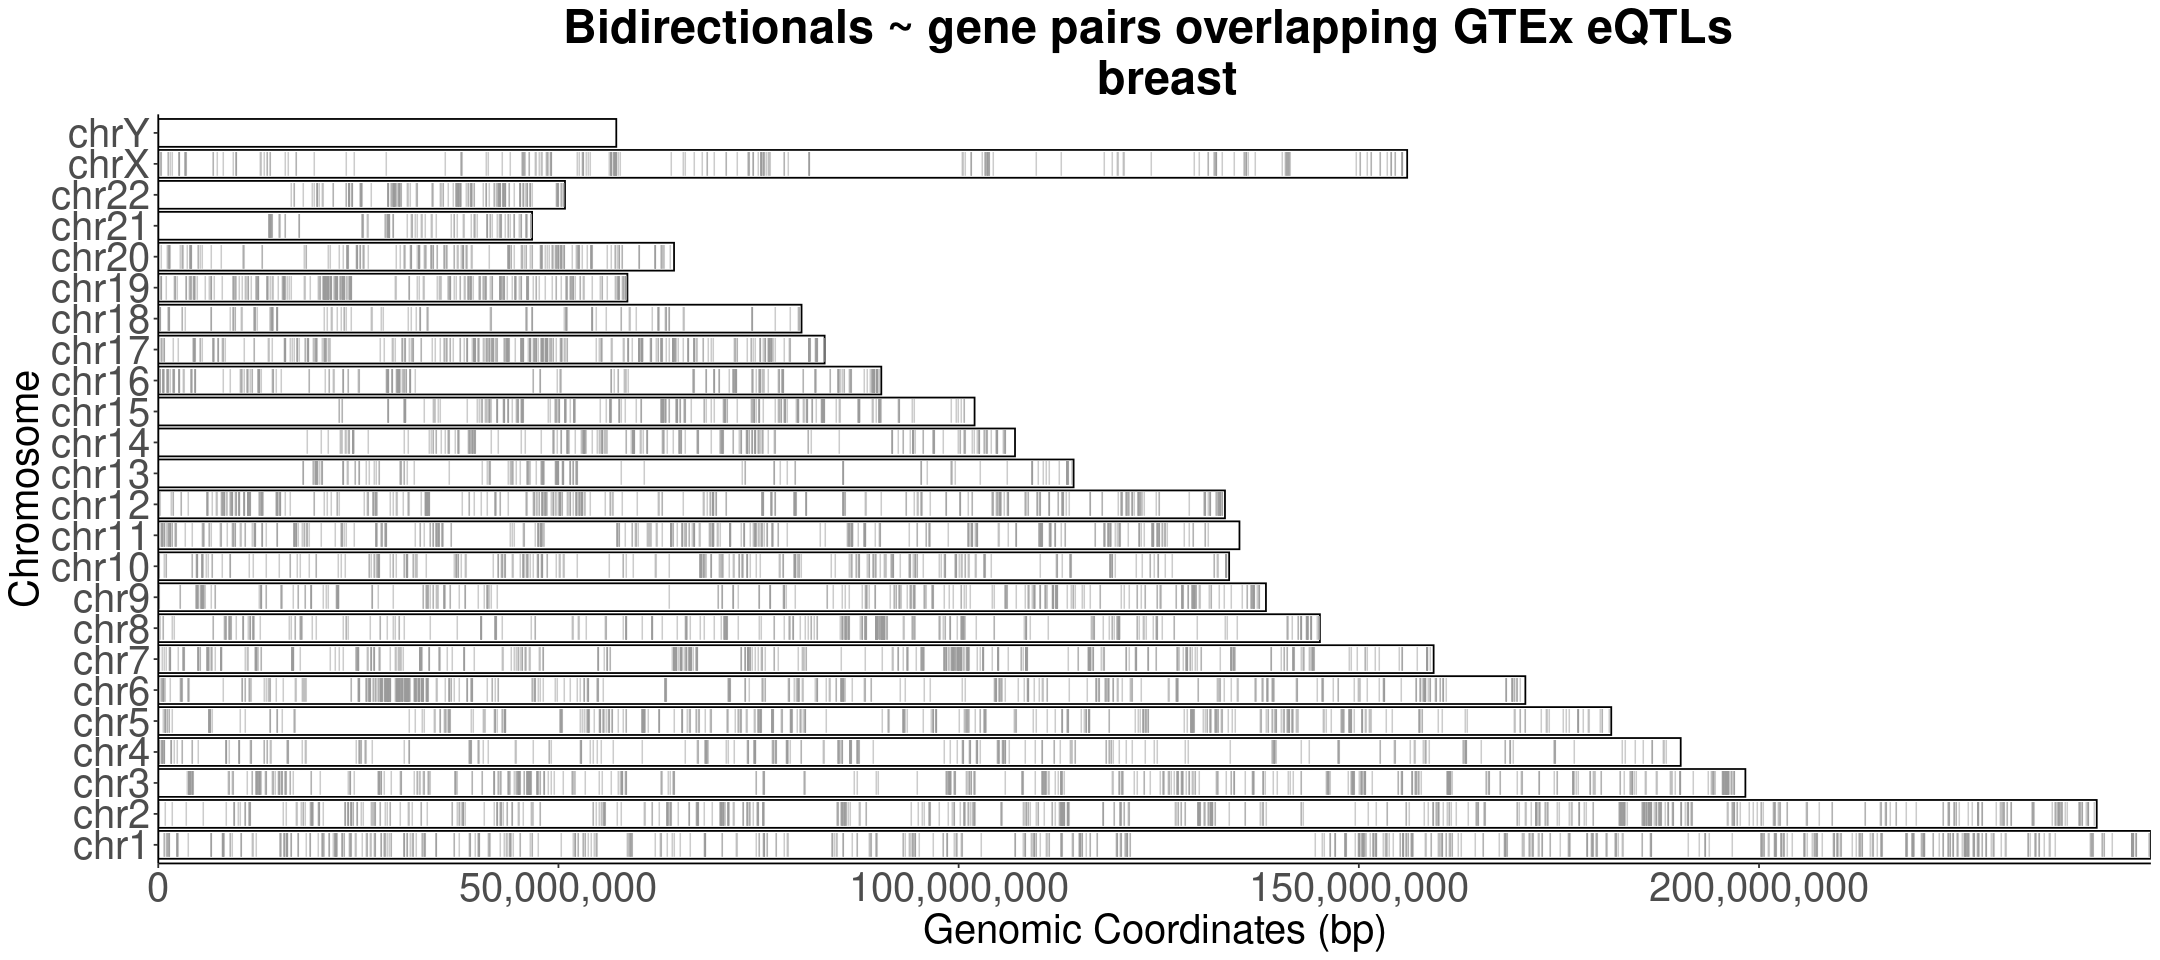

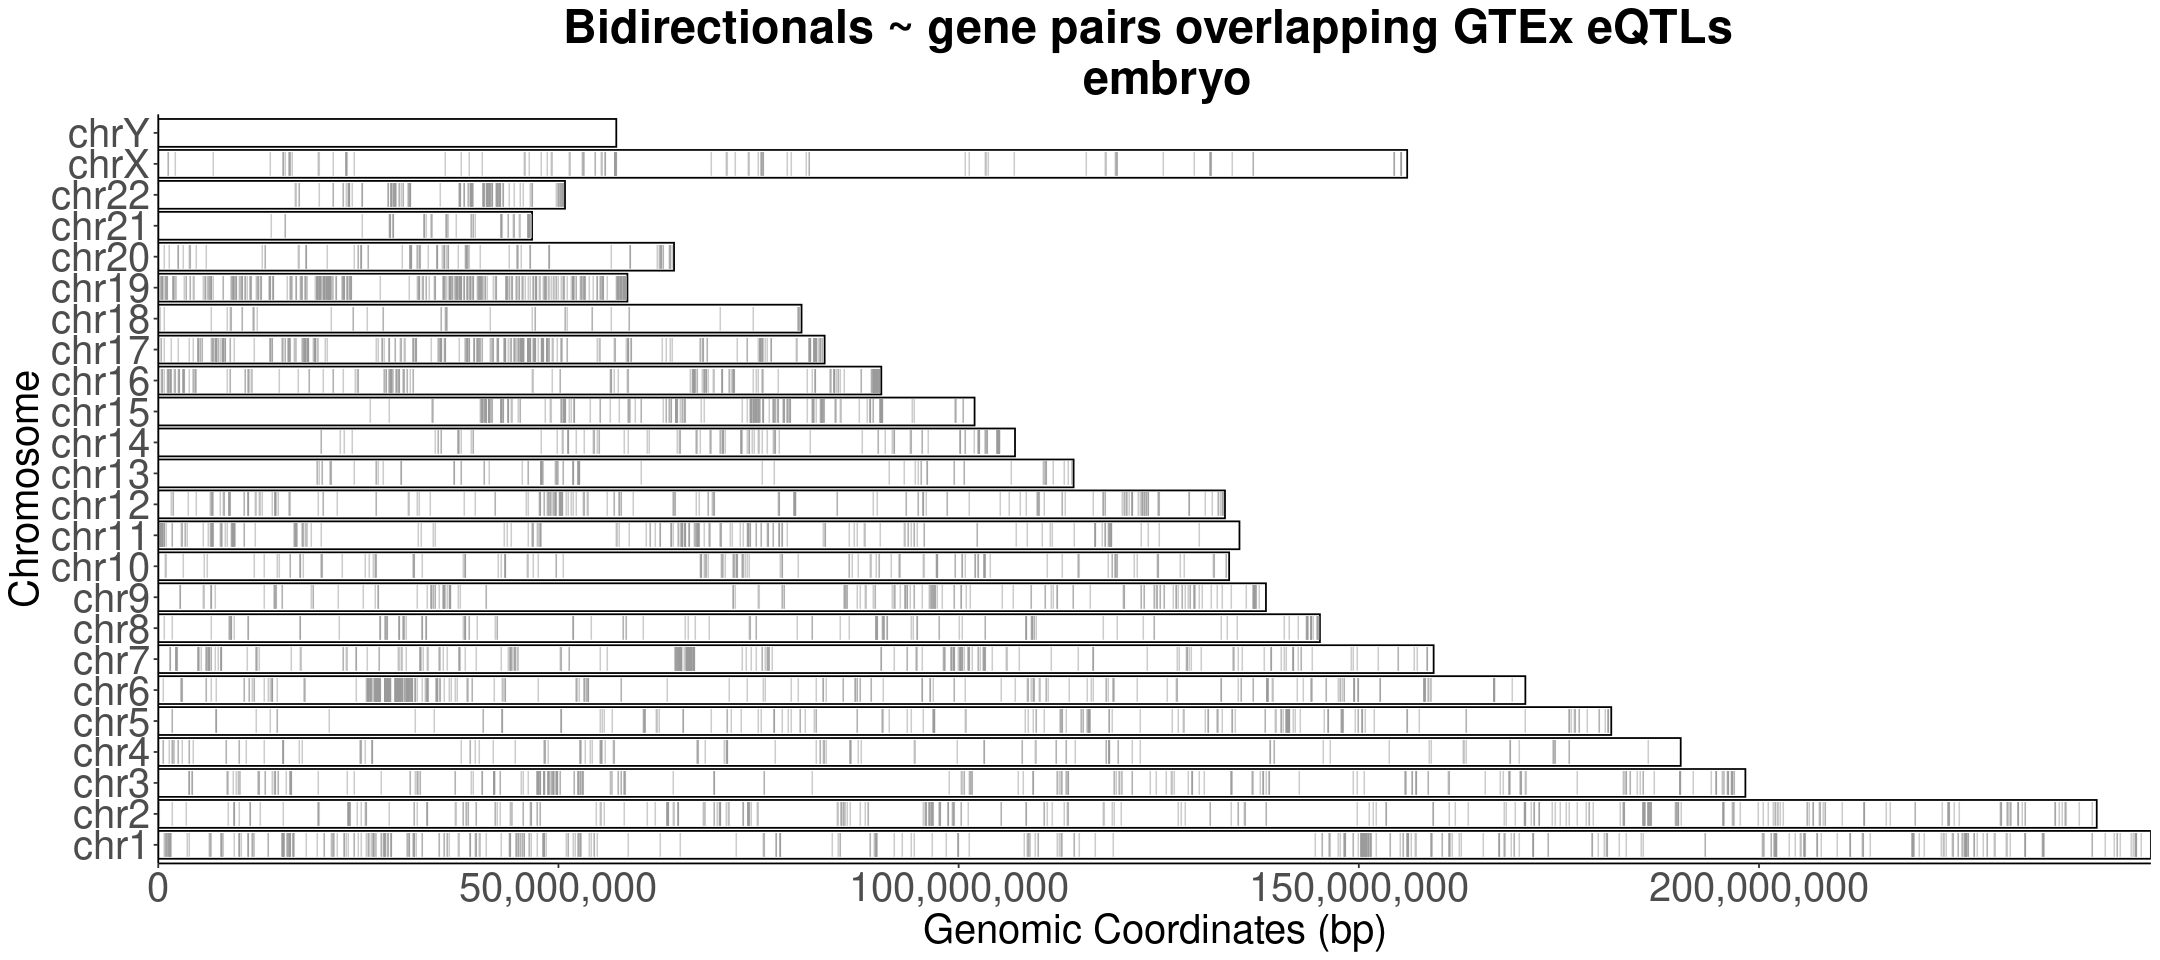

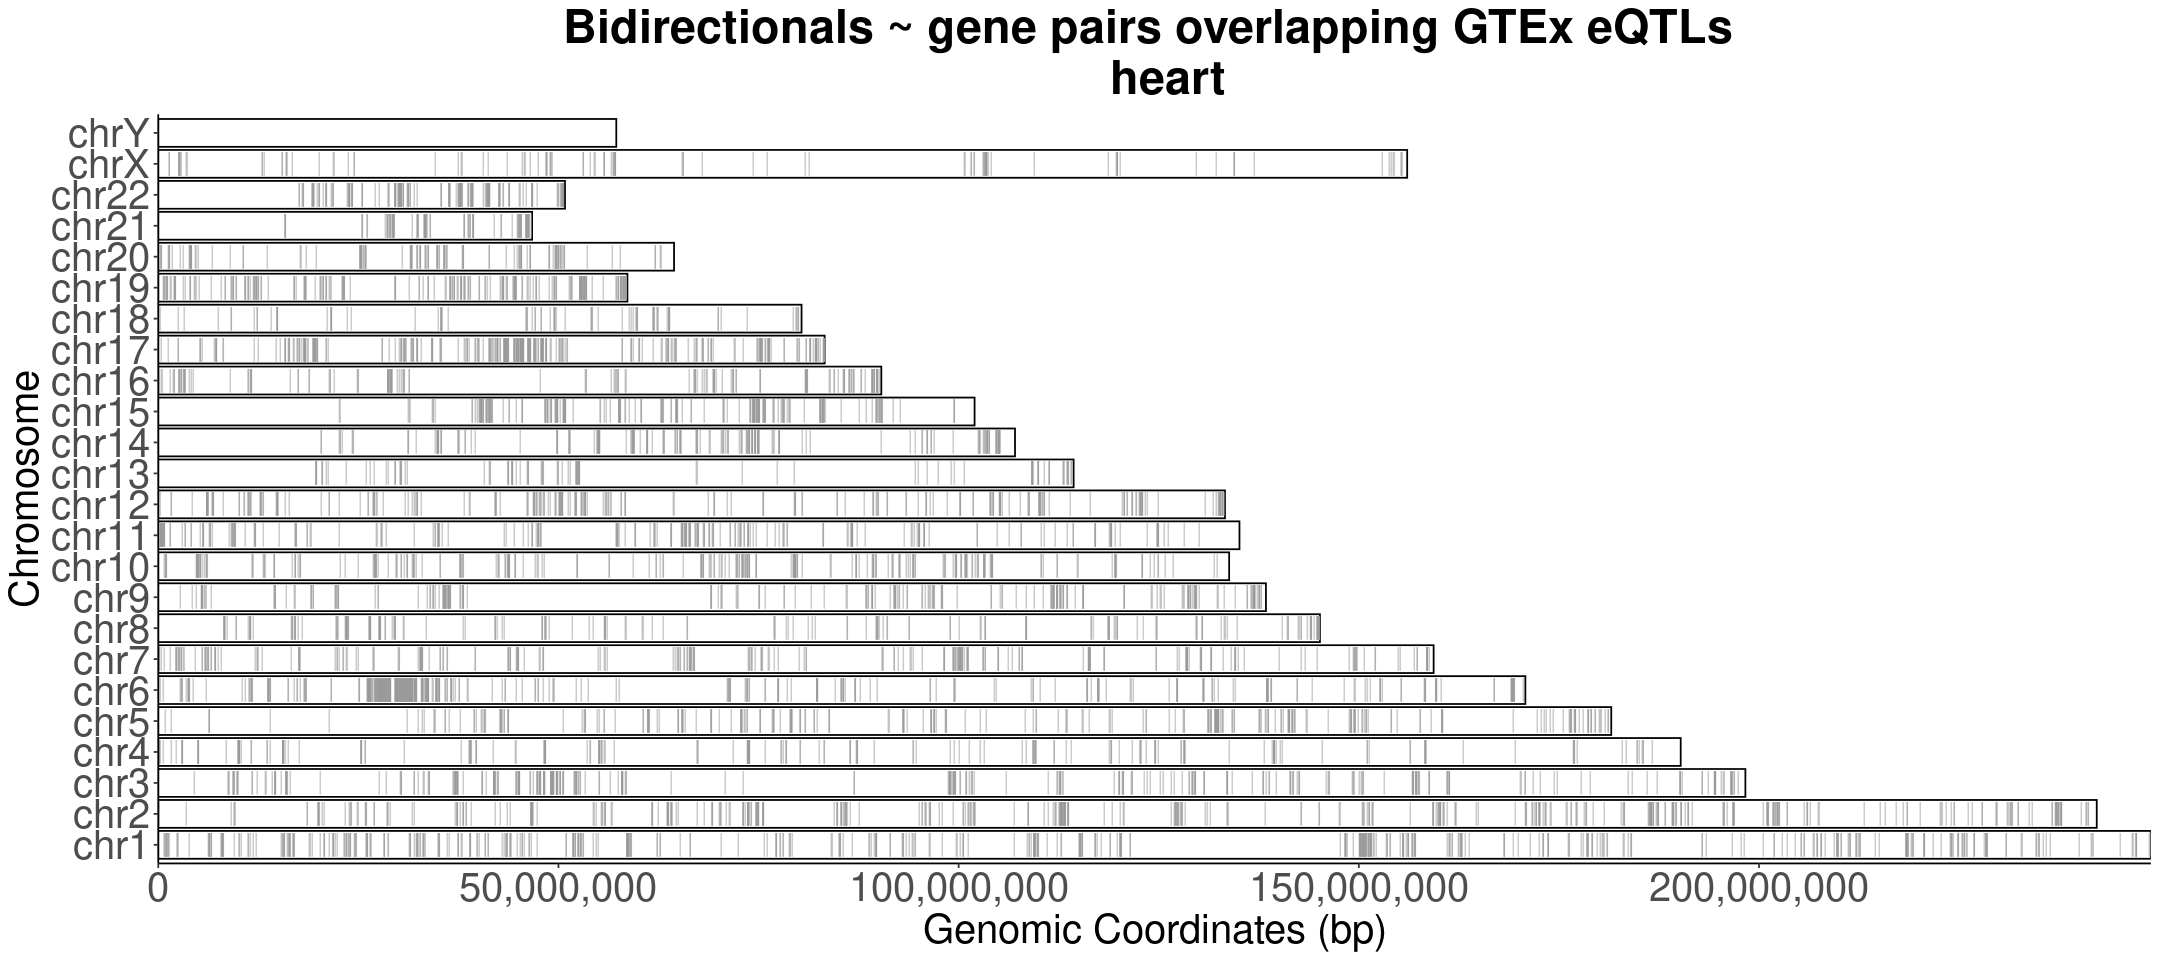

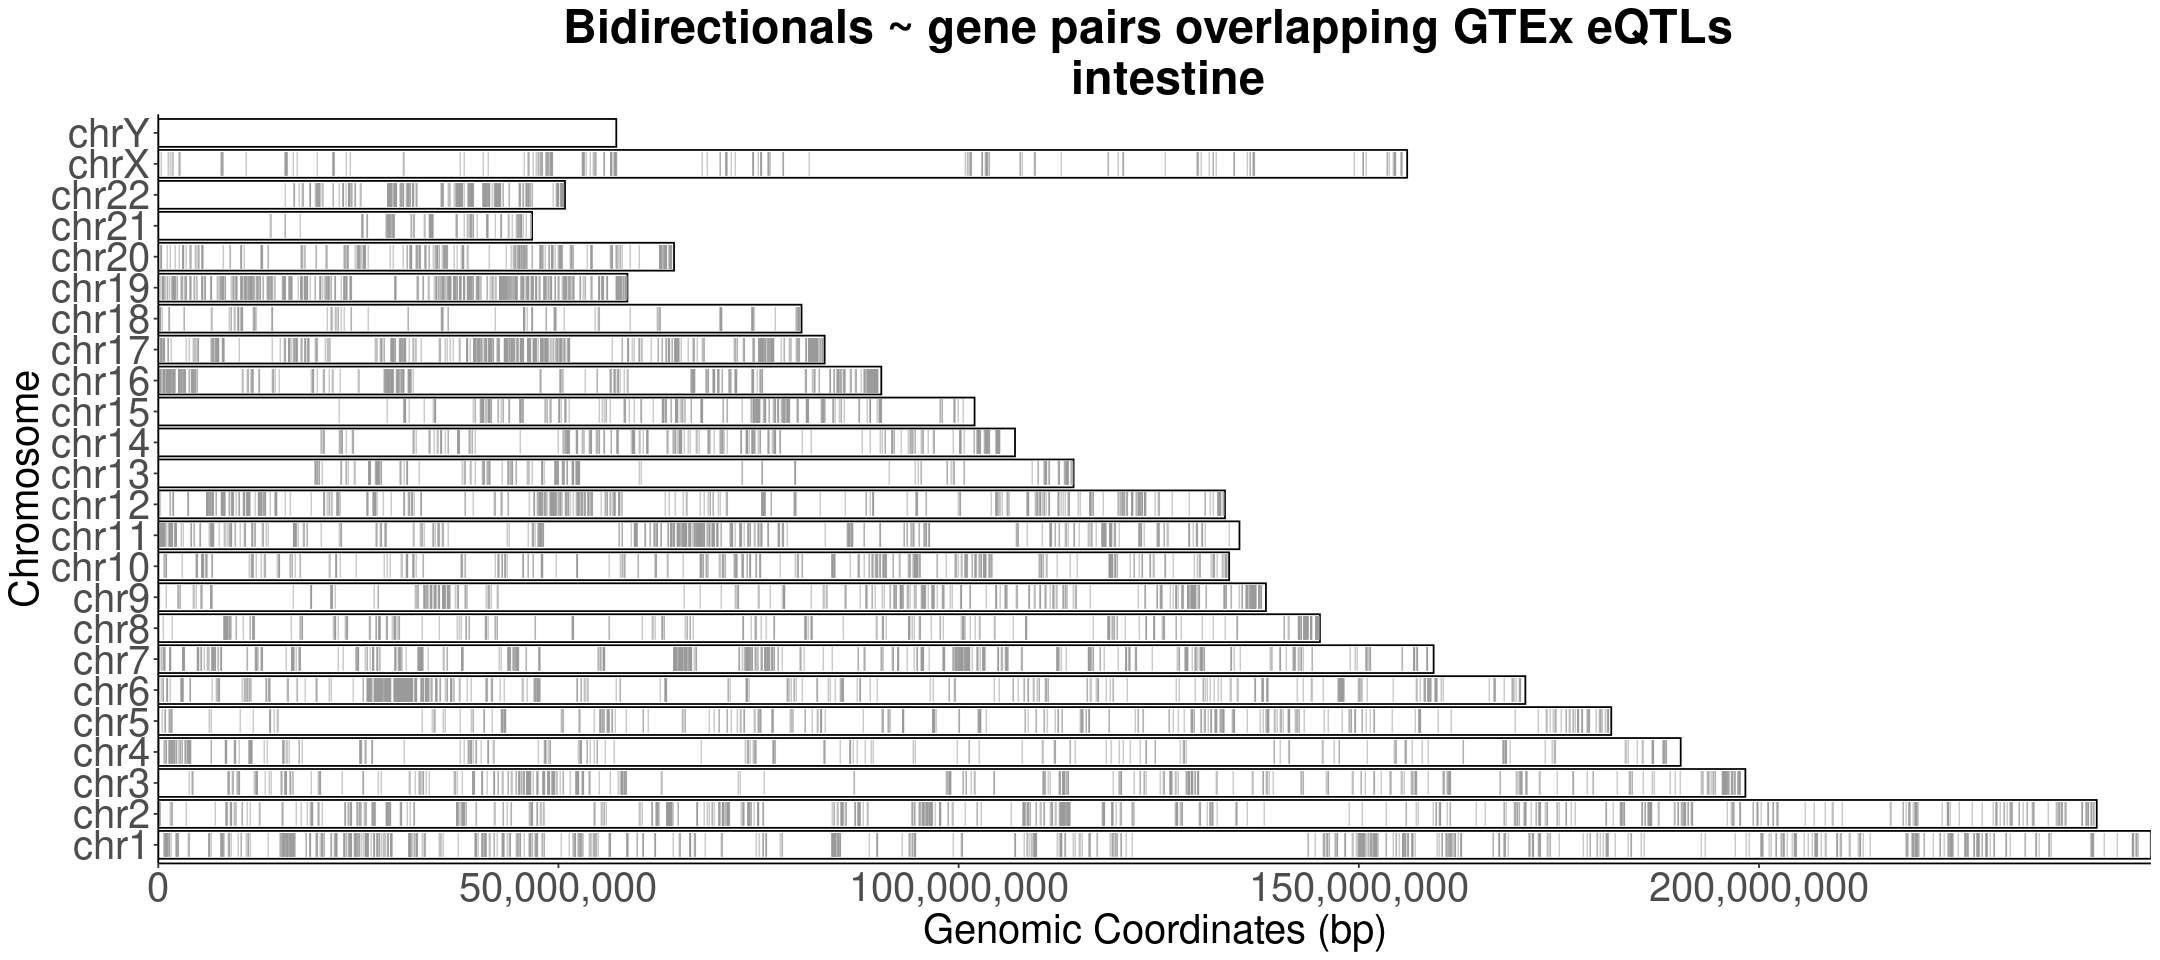

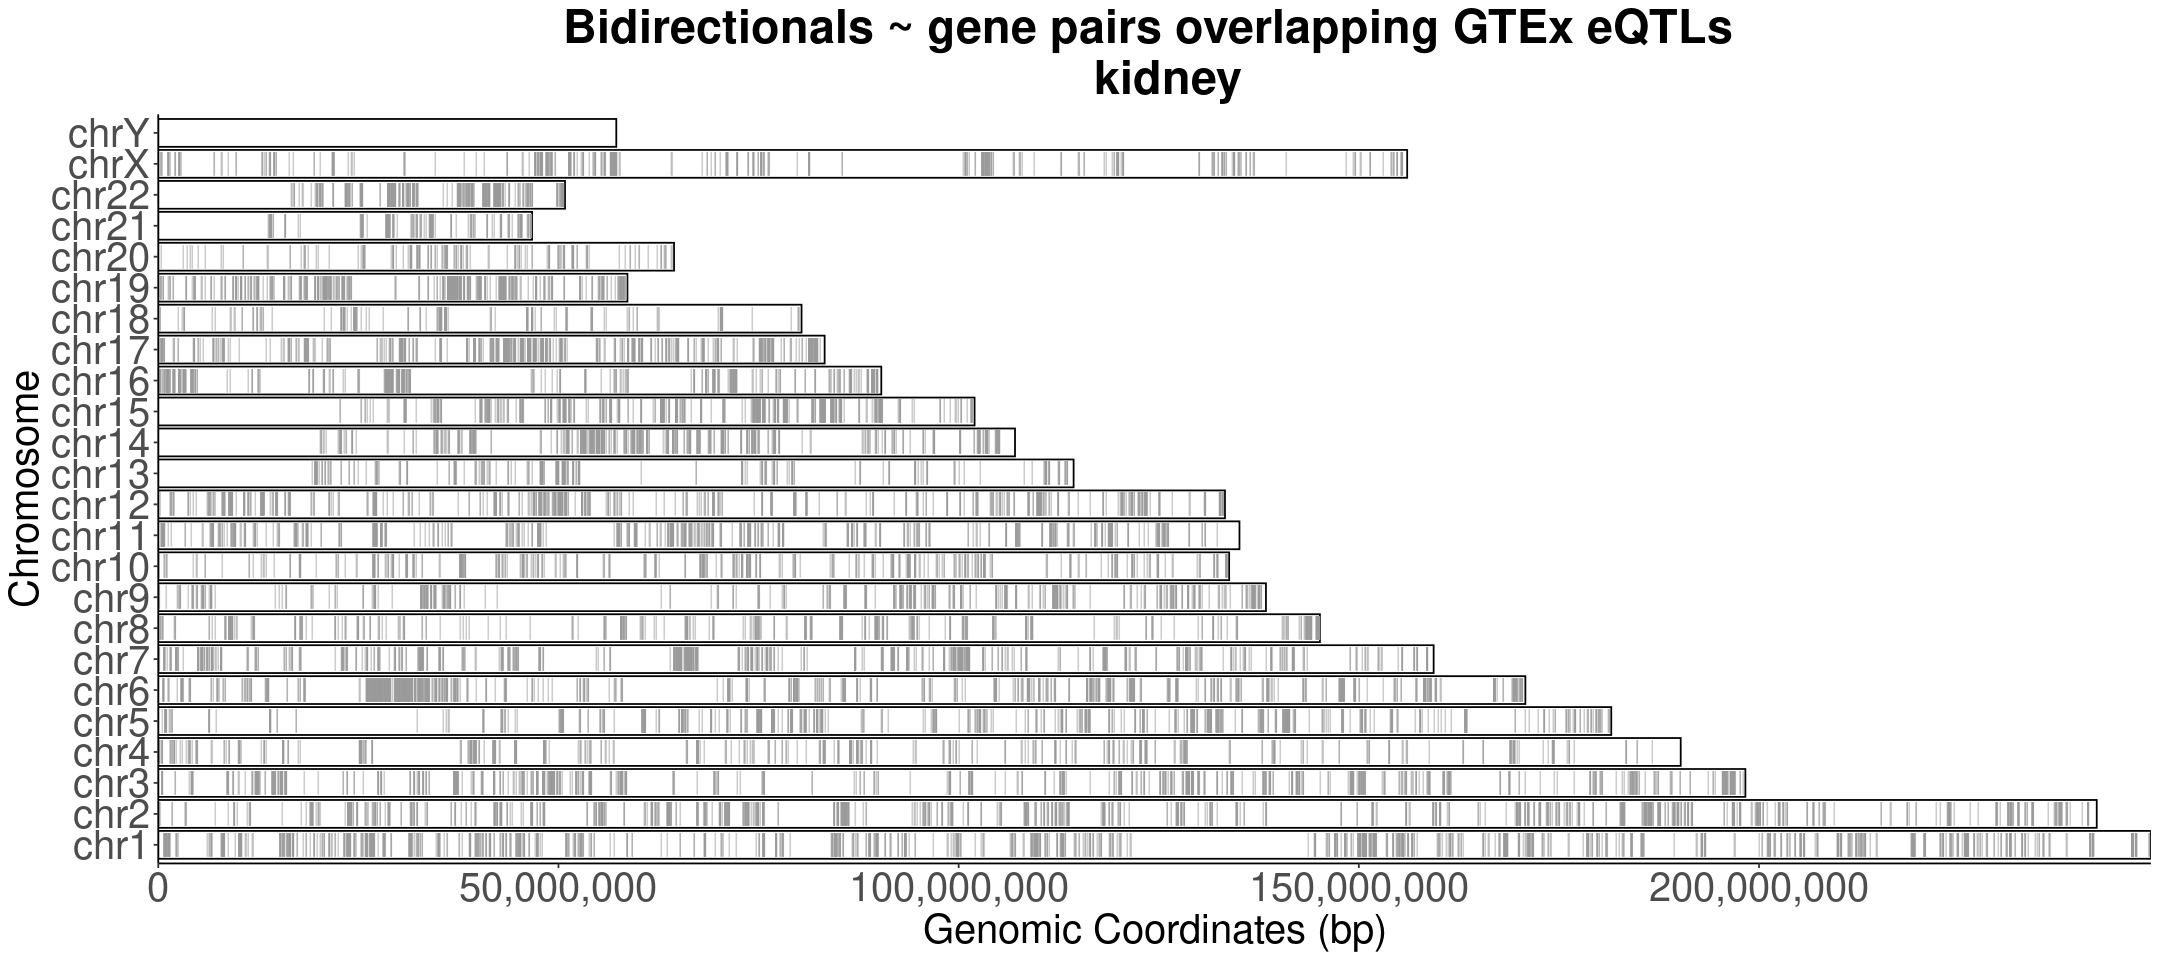

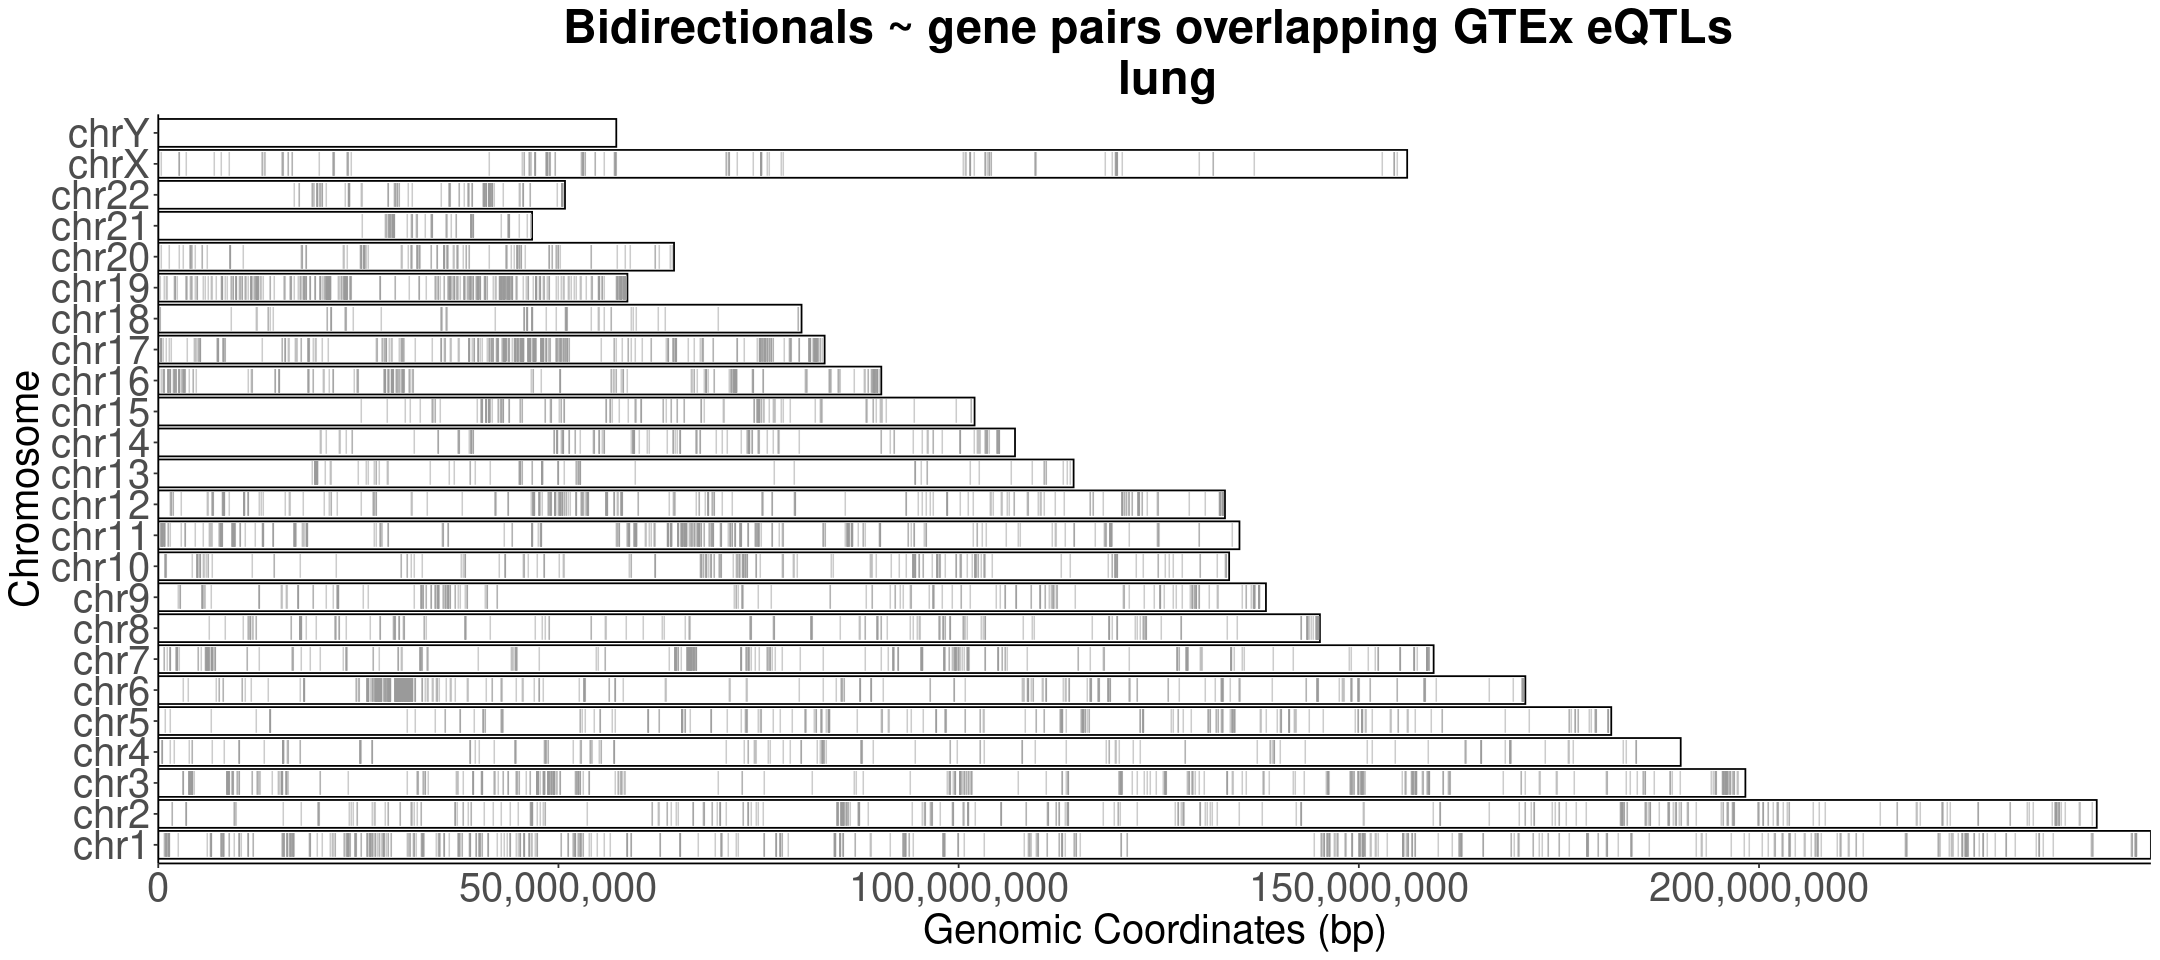

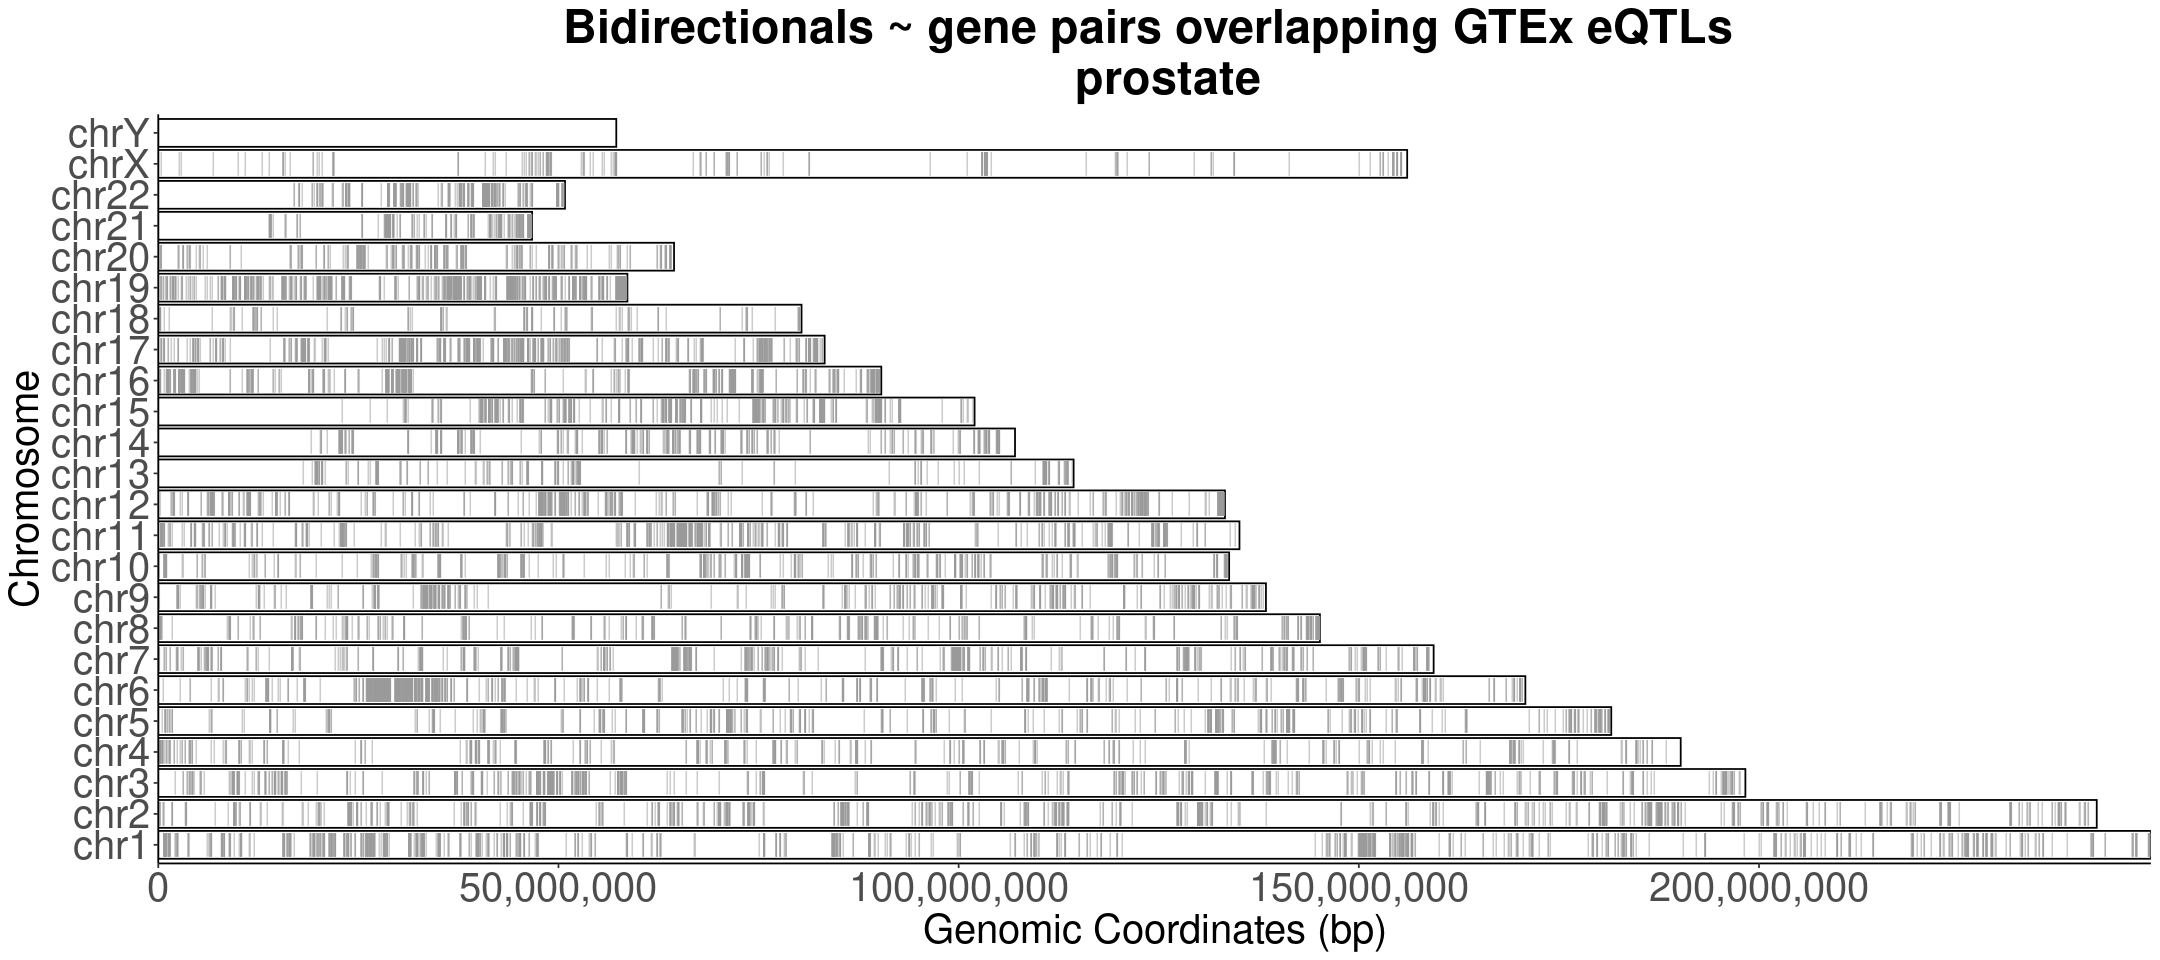

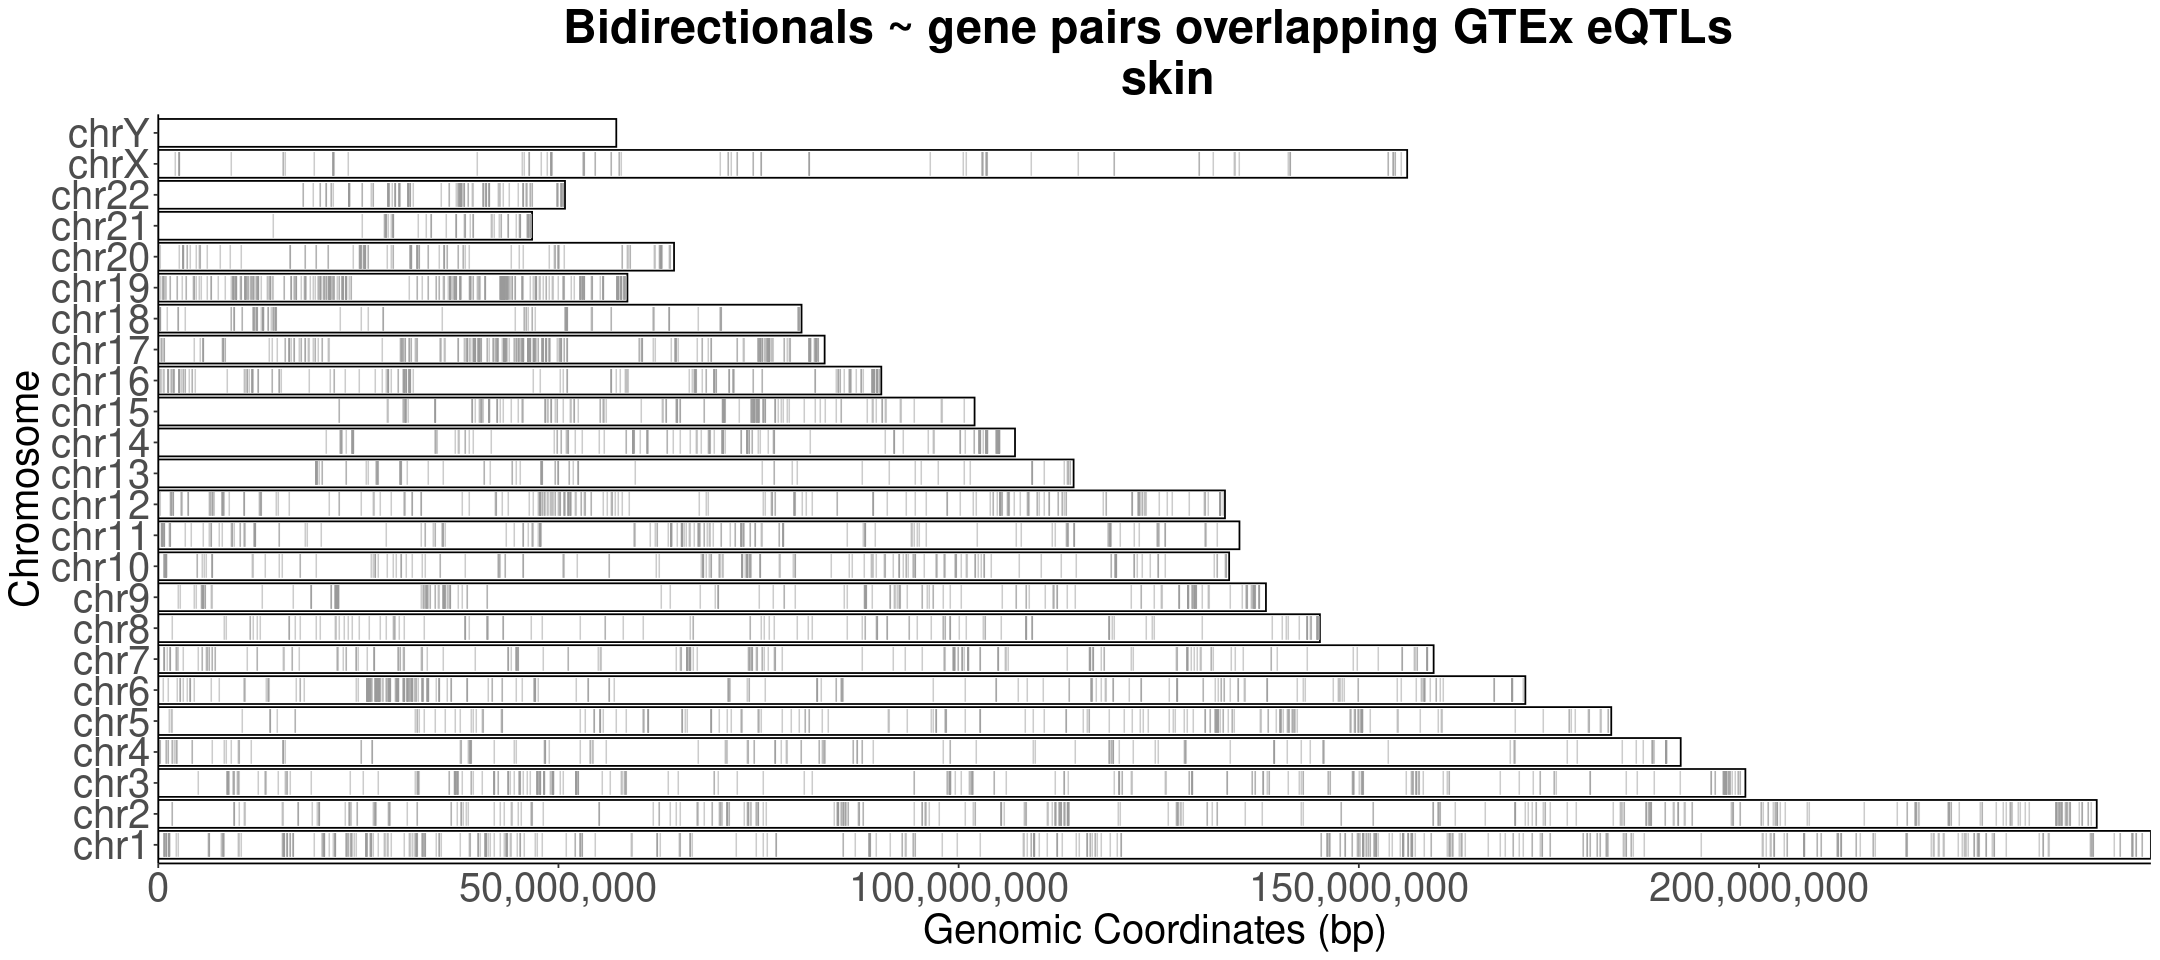

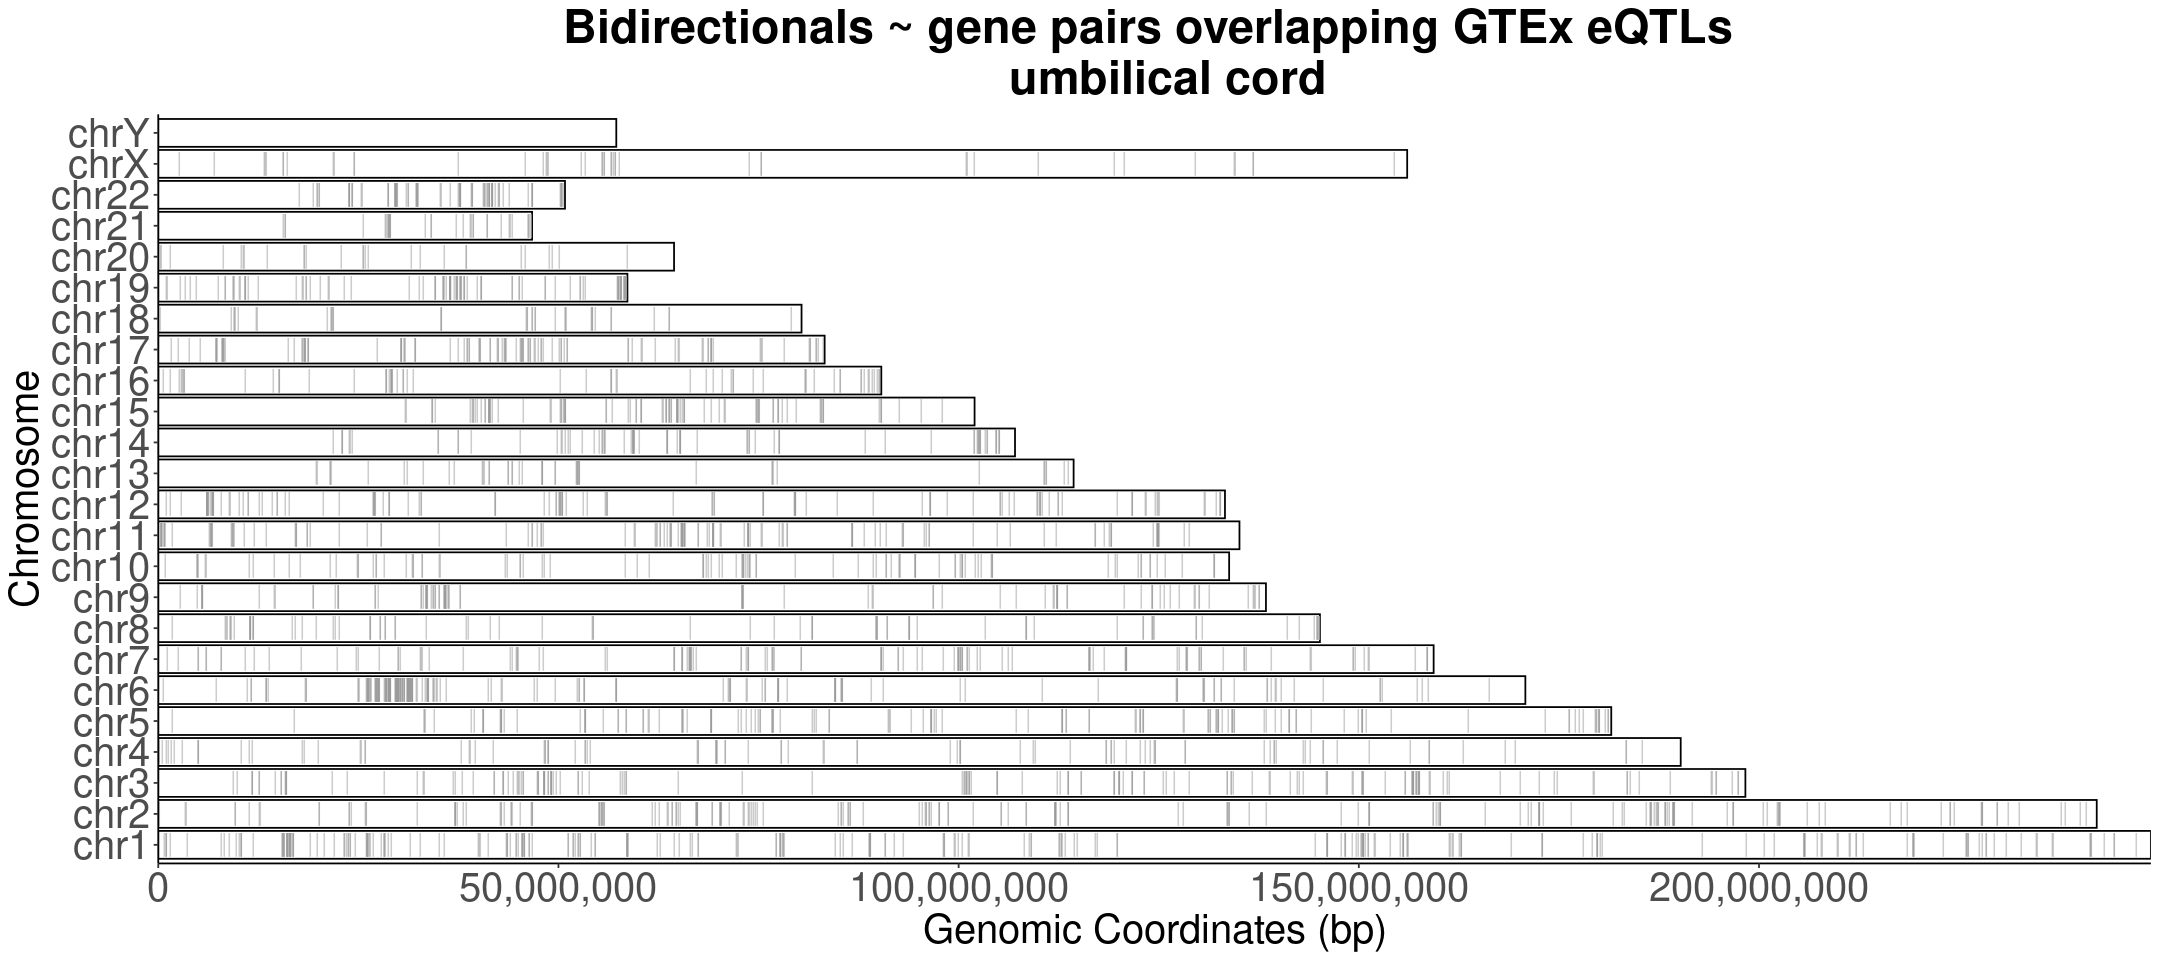

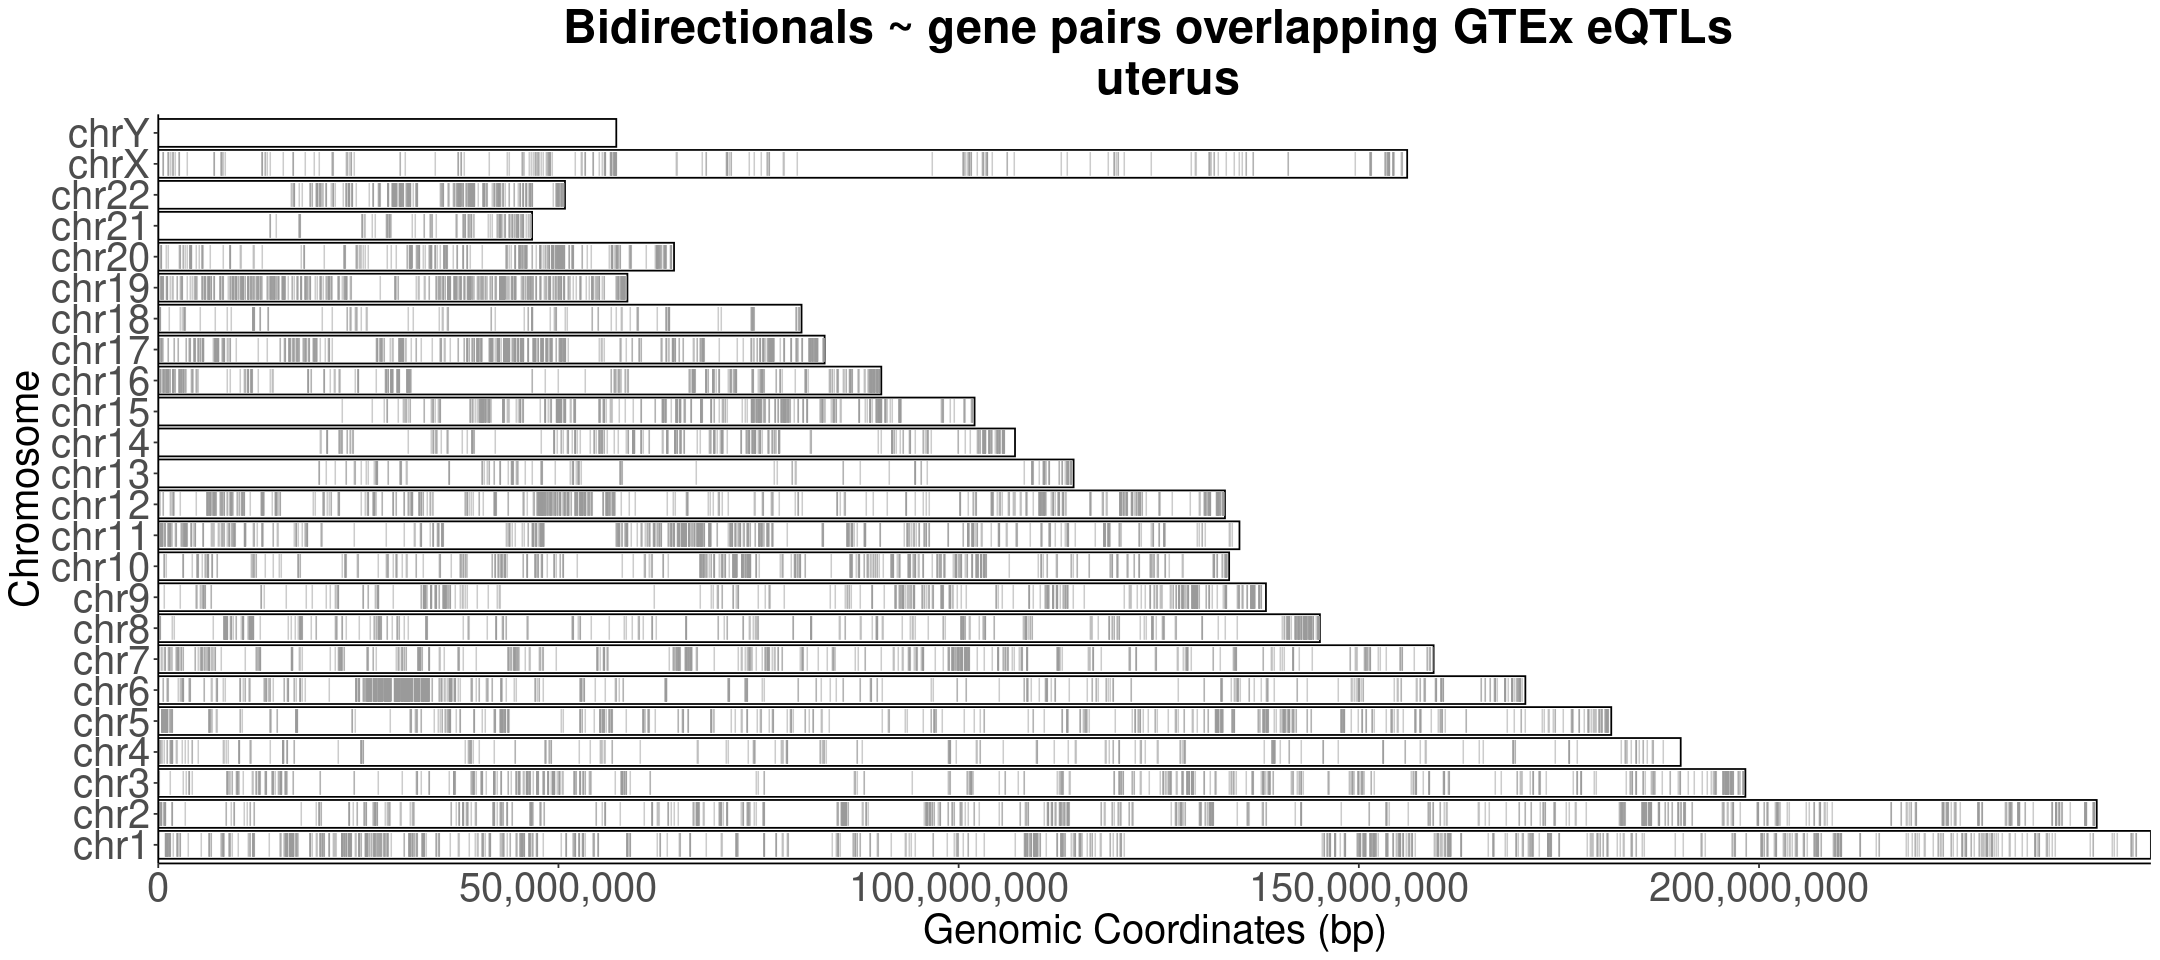

In [33]:
options(repr.plot.width=18, repr.plot.height=8)

tissues <- unique(sig_pairs_path_DT_filt$tissue)

for (i in tissues) {
    hg38_chrom_sizes <- read.table('/scratch/Shares/dowell/genomes/hg38/hg38.chrom.sizes.unsorted')
    hg38_chroms <- hg38_chrom_sizes[1:24,]
    hg38_chroms$chrs <- factor(hg38_chroms$V1, levels = hg38_chroms$V1)

    gtex_pairs_on_genome <- ggplot(data=hg38_chroms, 
           aes(y=chrs, x=V2)) +
    geom_bar(stat="identity", fill = 'white', color='black') +
    geom_point(data = subset(sig_pairs_path_DT_filt, gtex=='1'& tissue == i),
               aes(y = transcript2_chrom, x = transcript2_start), 
               shape=124, 
               color='gray60',
               size=5, 
               alpha=0.5) +
    xlab("Genomic Coordinates (bp)") +
    ylab("Chromosome") +
    ggtitle(paste("Bidirectionals ~ gene pairs overlapping GTEx eQTLs \n ", i)) +
    theme_classic() +
    scale_x_continuous(expand = c(0, 0), 
                       labels = scales::comma) +
    theme(plot.title = element_text(hjust = 0.5, 
                                    face = "bold",
                                   size = 28),
          axis.title = element_text(size = 24), 
          axis.text = element_text(size = 24),
          axis.text.x = element_text(size = 24),
         legend.title = element_text(size = 20),
         legend.text = element_text(size = 18))

    print(gtex_pairs_on_genome)
    
    }

# Session Information

In [34]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] data.table_1.14.2 cowplot_1.1.1     ggplot2_3.3.6    

loaded via a namespace (and not attached):
 [1] RColorBrewer_1.1-3 pillar_1.8.1       compiler_3.6.0     R.methodsS3_1.8.2 
 [5] R.utils_2.12.0     base64enc_0.1-3    tools_3.6.0        digest_0.6.29     
 [9] uuid_1.1-0         jsonlite_1.8.0     evaluate_0.16      lifecycle